In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
import torch

In [11]:
coarse_reso = 64
fine_reso = 4

def get_neighbors(pts):
        # pts should be in grid coordinates, ranging from 0 to coarse_reso * fine_reso
        offsets_3d = torch.tensor(
            [[-1, -1, -1],
            [-1, -1, 1],
            [-1, 1, -1],
            [-1, 1, 1],
            [1, -1, -1],
            [1, -1, 1],
            [1, 1, -1],
            [1, 1, 1]], dtype=pts.dtype, device=pts.device)
        pre_floor = pts[:,None,:] + offsets_3d[None,...] / 2.
        post_floor = torch.clamp(torch.floor(pre_floor), min=0., max=coarse_reso * fine_reso - 1) # index
        return torch.abs(pts - (post_floor + 0.5)), post_floor.long()

get_neighbors(torch.tensor([[5.2,34.1,5.5]]))

(tensor([[[0.7000, 0.6000, 0.0000],
          [0.7000, 0.6000, 1.0000],
          [0.7000, 0.4000, 0.0000],
          [0.7000, 0.4000, 1.0000],
          [0.3000, 0.6000, 0.0000],
          [0.3000, 0.6000, 1.0000],
          [0.3000, 0.4000, 0.0000],
          [0.3000, 0.4000, 1.0000]]]),
 tensor([[[ 4, 33,  5],
          [ 4, 33,  6],
          [ 4, 34,  5],
          [ 4, 34,  6],
          [ 5, 33,  5],
          [ 5, 33,  6],
          [ 5, 34,  5],
          [ 5, 34,  6]]]))

In [2]:
import math
import copy
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import tc_plenoptimize as tcp
import tc_plenoxel
import config

In [47]:
cfg = config.get_cfg_defaults()
cfg.optim.num_epochs = 1
cfg.optim.progress_refresh_rate = 100

cfg.grid.occupancy_thresh = 2.
# cfg.optim.batch_size = 8000
cfg.grid.update_occ_iters = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
# cfg.grid.upsample_iters = [4000, ]
# cfg.grid.shrink_iters = []#1000, 2000, 3000, 4000, 6000, 6500, 7000, 7500]

# cfg.optim.occupancy_penalty = 0.0001
# cfg.optim.regularization.tv_sigma_weight = 1e-5

cfg.irreg_grid.count_intersections = "tensorrf"
print(cfg)

data:
  datadir: /home/giacomo/plenoxels/lego
  downsample: 1.0
  max_tr_frames: None
  max_ts_frames: None
  resolution: 128
expname: hg_exp_5
grid:
  abs_light_thresh: 0.0001
  ini_rgb: 0.0
  ini_sigma: 0.0
  occupancy_thresh: 2.0
  reso_multiplier: 1.5
  shrink_iters: [4000, 5000, 8000, 9000]
  update_occ_iters: [200, 300, 400, 500, 600, 700, 800, 900, 1000]
  upsample_iters: [2000, 6000, 36000]
hash_grid:
  log2_hashmap_size: 19
irreg_grid:
  count_intersections: tensorrf
  prune_threshold: 0.001
  voxel_mul: 2.0
logdir: ./logs/
model_type: regular_grid
optim:
  adam:
    lr: 0.5
  batch_size: 8000
  eval_refresh_rate: 8000
  lr_rgb: None
  lr_sigma: None
  num_epochs: 1
  occupancy_penalty: 0.001
  optimizer: rmsprop
  profile: False
  progress_refresh_rate: 100
  regularization:
    sparsity_weight: 0.0
    tv_sh_weight: 0.001
    tv_sigma_weight: 1e-05
    tv_subsample: 100
    types: ['TV']
  render_refresh_rate: 20
seed: 42
sh:
  degree: 2
  sh_encoder: plenoxels


In [48]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

def plot_cube(ax, cube_definition):
    cube_definition_array = [
        np.array(list(item))
        for item in cube_definition
    ]

    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]

    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

    points = np.array(points)

    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]
    faces = Poly3DCollection(edges, linewidths=1, edgecolors='k')
    faces.set_facecolor((0,0,1,0.1))

    ax.add_collection3d(faces)

    # Plot the points themselves to force the scaling of the axes
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0)


In [6]:
h_degree = cfg.sh.degree
resolution = cfg.data.resolution
dev = "cuda:0"
tr_dset, tr_loader, ts_dset = tcp.init_datasets(cfg, dev)

Loading test data: 100%|██████████| 200/200 [00:09<00:00, 22.17it/s]


In [50]:
def init_optim(model_, lrs_):
    optim = "rmsprop"
    if optim == "rmsprop":
        return torch.optim.RMSprop(params=[
            {'params': (model_.rgb_data, ), 'lr': 0.1},
            {'params': (model_.sigma_data, ), 'lr': 10.}
        ])
    elif optim == "sgd":
        return torch.optim.SGD(params=[
            {'params': (model_.rgb_data, ), 'lr': lrs[0]},
            {'params': (model_.sigma_data, ), 'lr': lrs[-1]}
        ])

In [51]:
lrs = tcp.init_plenoxel_lrs(cfg, h_degree, dev)
sh_enc = tcp.init_sh_encoder(cfg, h_degree)
occupancy_penalty = cfg.optim.occupancy_penalty / (len(tr_dset) // cfg.optim.batch_size)
# Initialize model
model = tc_plenoxel.RegularGrid(
    resolution=torch.tensor([resolution, resolution, resolution], dtype=torch.int32),
    aabb=tr_dset.scene_bbox,
    deg=h_degree,
    ini_sigma=cfg.grid.ini_sigma,
    ini_rgb=cfg.grid.ini_rgb,
    sh_encoder=sh_enc,
    white_bkgd=tr_dset.white_bg,
    uniform_rays=0.5,
    count_intersections=cfg.irreg_grid.count_intersections,
    near_far=tuple(tr_dset.near_far),
    abs_light_thresh=cfg.grid.abs_light_thresh,
    occupancy_thresh=cfg.grid.occupancy_thresh,
    voxel_mul=cfg.irreg_grid.voxel_mul,
).to(dev)
optim = init_optim(model, lrs)

Learning rates:  [1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 10160728.636348171]
Voxel length 1.023e-02 - Num intersections 440


In [52]:
# Main iteration starts here
for epoch in range(1):
    psnrs, mses = [], []
    model = model.train()
    for i, batch in enumerate(tr_loader):
        g_iter = epoch * len(tr_loader) + i + 1
        optim.zero_grad()
        rays, imgs = batch
        rays = rays.to(device=dev)
        rays_o = rays[:, 0].contiguous()
        rays_d = rays[:, 1].contiguous()
        imgs = imgs.to(device=dev)
        preds, _, _ = model(rays_o=rays_o, rays_d=rays_d)
        loss = F.mse_loss(preds, imgs)
        total_loss = loss + model.approx_density_tv_reg(
            subsampling=cfg.optim.regularization.tv_subsample,
            sh_weight=cfg.optim.regularization.tv_sh_weight,
            sigma_weight=cfg.optim.regularization.tv_sigma_weight)
        total_loss.backward()
        optim.step()

        # Reporting
        loss = loss.detach().item()
        psnrs.append(-10.0 * math.log(loss) / math.log(10.0))
        mses.append(loss)
        if i % cfg.optim.progress_refresh_rate == 0:
            print(f"Epoch {epoch} - iteration {i}: "
                  f"MSE {np.mean(mses):.4f} PSNR {np.mean(psnrs):.4f}")
            psnrs, mses = [], []
            model.shrink(False)

        if g_iter in cfg.grid.update_occ_iters:
            model.update_occupancy()
        if g_iter in cfg.grid.shrink_iters:
            model.shrink()
        if g_iter in cfg.grid.upsample_iters:
            model.upscale(new_resolution=(model.resolution * cfg.grid.reso_multiplier).long())
        if model.params_changed:
            lrs[0] = 150 * (torch.mean(model.resolution.float()).item() ** 1.75) * (cfg.optim.batch_size / 4000)
            lrs[-1] = 51.5 * (torch.mean(model.resolution.float()).item() ** 2.37) * (cfg.optim.batch_size / 4000)
            optim = init_optim(model, lrs)
            model.params_changed = False
        if g_iter > 3000:
            break

Epoch 0 - iteration 0: MSE 0.1236 PSNR 9.0815
Epoch 0 - iteration 100: MSE 0.0260 PSNR 18.7231
Updated occupancy. Have 4.52% entries full
Epoch 0 - iteration 200: MSE 0.0037 PSNR 24.3819
Updated occupancy. Have 4.77% entries full
Epoch 0 - iteration 300: MSE 0.0025 PSNR 26.0652
Updated occupancy. Have 4.83% entries full
Epoch 0 - iteration 400: MSE 0.0020 PSNR 26.9577
Updated occupancy. Have 4.96% entries full
Epoch 0 - iteration 500: MSE 0.0017 PSNR 27.6012
Updated occupancy. Have 4.99% entries full
Epoch 0 - iteration 600: MSE 0.0016 PSNR 27.9725
Updated occupancy. Have 5.04% entries full
Epoch 0 - iteration 700: MSE 0.0015 PSNR 28.2597
Updated occupancy. Have 5.08% entries full
Epoch 0 - iteration 800: MSE 0.0014 PSNR 28.5292
Updated occupancy. Have 5.14% entries full
Epoch 0 - iteration 900: MSE 0.0014 PSNR 28.6979
Updated occupancy. Have 5.21% entries full
Epoch 0 - iteration 1000: MSE 0.0013 PSNR 28.7589
Epoch 0 - iteration 1100: MSE 0.0013 PSNR 28.8037
Epoch 0 - iteration 1200: 

```{'params': (model_.rgb_data, ), 'lr': 0.1},
{'params': (model_.sigma_data, ), 'lr': 1.}
Updated occupancy. Have 7.91% entries full
Epoch 0 - iteration 500: MSE 0.0013 PSNR 29.0329```

```{'params': (model_.rgb_data, ), 'lr': 0.5},
{'params': (model_.sigma_data, ), 'lr': 1.}
Updated occupancy. Have 11.84% entries full
Epoch 0 - iteration 500: MSE 0.0018 PSNR 27.4602
```

```{'params': (model_.rgb_data, ), 'lr': 0.05},
{'params': (model_.sigma_data, ), 'lr': 1.}
Updated occupancy. Have 7.21% entries full
Epoch 0 - iteration 500: MSE 0.0015 PSNR 28.3453
```

```{'params': (model_.rgb_data, ), 'lr': 0.1},
{'params': (model_.sigma_data, ), 'lr': 5.}
Updated occupancy. Have 46.88% entries full
Epoch 0 - iteration 500: MSE 0.0214 PSNR 16.6988```

```{'params': (model_.rgb_data, ), 'lr': 0.1},
{'params': (model_.sigma_data, ), 'lr': 0.1}
Updated occupancy. Have 8.57% entries full
Epoch 0 - iteration 500: MSE 0.0021 PSNR 26.8476```

```1e-2 TV sigma weight
Updated occupancy. Have 18.50% entries full
Epoch 0 - iteration 500: MSE 0.0029 PSNR 25.3144```

```SGD optim, 1e-5 TV sigma weight
Updated occupancy. Have 7.18% entries full
Epoch 0 - iteration 500: MSE 0.0020 PSNR 26.9467```

In [53]:
model.cpu()

RegularGrid()

In [54]:
density = model.sigma_data
density = density.squeeze().cpu().detach()
density.shape

torch.Size([192, 192, 192])

In [55]:
calc_potential_shrinkage(density)

Old Bounds: [0, 0, 0] -- tensor([192, 192, 192])
New Bounds: tensor([46, 10, 45]) -- tensor([171, 190, 147])


(tensor([46, 10, 45]), tensor([171, 190, 147]))

<IPython.core.display.Javascript object>


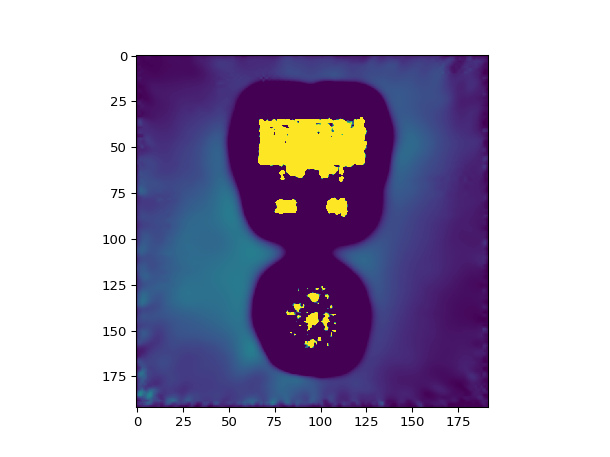

In [79]:
fig, ax = plt.subplots()
ax.imshow(density[147, :, :], vmin=0, vmax=2)

In [601]:
# large_model = copy.deepcopy(model.cpu())
model = copy.deepcopy(large_model.cpu())
# model.occupancy = None

In [602]:
def calc_potential_shrinkage(density, thresh=2):
    ooc_mask = density > thresh
    resolution = torch.tensor(density.shape)
    xyz_min, xyz_max = torch.empty(3, dtype=torch.long), torch.empty(3, dtype=torch.long)
    i_coord = ooc_mask.amax(0)
    ij_coord = i_coord.amax(0)
    xyz_min[2] = torch.max(ij_coord, dim=0).indices
    xyz_max[2] = len(ij_coord) - torch.max(ij_coord.flip(0), dim=0).indices
    ik_coord = i_coord.amax(1)
    xyz_min[1] = torch.max(ik_coord, dim=0).indices
    xyz_max[1] = len(ik_coord) - torch.max(ik_coord.flip(0), dim=0).indices
    j_coord = ooc_mask.amax(1)
    ji_coord = j_coord.amax(1)
    xyz_min[0] = torch.max(ji_coord, dim=0).indices
    xyz_max[0] = len(ji_coord) - torch.max(ji_coord.flip(0), dim=0).indices
    print(f"Old Bounds: [0, 0, 0] -- {resolution}")
    print(f"New Bounds: {xyz_min} -- {xyz_max}")
    return xyz_min, xyz_max

def shrink2reso(model, xyz_min, xyz_max, flip: bool):
    model.resolution = model.resolution.flip(0)
    model.aabb = model.aabb.flip(1)
    units = model.aabb_size / (model.resolution)
    new_aabb = torch.empty_like(model.aabb)
    new_aabb[0] = model.aabb[0] + xyz_min * units
    new_aabb[1] = model.aabb[1] - (model.resolution - xyz_max) * units
    new_reso = xyz_max - xyz_min
    if (new_reso == model.resolution).all():
        print("No shrinkage possible.")
        return
    # Now actually shrink the data
    model.sigma_data = torch.nn.Parameter(
        model.sigma_data[:, :, xyz_min[0]: xyz_max[0], xyz_min[1]: xyz_max[1], xyz_min[2]: xyz_max[2]], requires_grad=True)
    model.rgb_data = torch.nn.Parameter(
        model.rgb_data[:, :, xyz_min[0]: xyz_max[0], xyz_min[1]: xyz_max[1], xyz_min[2]: xyz_max[2]], requires_grad=True)
    if model.occupancy is not None:
        model.occupancy = model.occupancy[
             :, :, xyz_min[0]: xyz_max[0], xyz_min[1]: xyz_max[1], xyz_min[2]: xyz_max[2]]
    model.resolution = new_reso#.flip(0)
    model.aabb = new_aabb#.flip(1)
    model.params_changed = False
    print("New Resolution", model.resolution)
    print("New data size", model.sigma_data.shape)
    print("New AABB", model.aabb)

def upscale(model, new_reso):
    with torch.autograd.no_grad():
        new_res_s = (new_reso[0].item(), new_reso[1].item(), new_reso[2].item())
        print("Upsampling to new resolution %s from %s" % (new_res_s, model.resolution ))
        new_sigma = F.interpolate(
            model.sigma_data, size=new_res_s, align_corners=True, mode='trilinear')
        delattr(model, "sigma_data")
        model.sigma_data = torch.nn.Parameter(new_sigma, requires_grad=True)

        new_rgb = F.interpolate(
            model.rgb_data, size=new_res_s, align_corners=True, mode='trilinear')
        delattr(model, "rgb_data")
        model.rgb_data = torch.nn.Parameter(new_rgb, requires_grad=True)

        if model.occupancy is not None:
            model.occupancy = F.interpolate(
                model.occupancy, size=new_res_s, align_corners=True, mode='trilinear')
        print("New data size", model.sigma_data.shape)
        model.resolution = new_reso

In [610]:
xyz_min, xyz_max = calc_potential_shrinkage(model.sigma_data.detach().cpu().squeeze(), thresh=1)

Old Bounds: [0, 0, 0] -- tensor([192, 192, 192])
New Bounds: tensor([31, 10,  1]) -- tensor([191, 191, 147])


In [611]:
shrink2reso(model, xyz_min, xyz_max, flip=True)

Voxel length 6.803e-03 - Num intersections 662
Voxel length 6.803e-03 - Num intersections 662
Voxel length 8.114e-03 - Num intersections 555
Voxel length 6.801e-03 - Num intersections 562
New Resolution tensor([160, 181, 146], dtype=torch.int32)
New data size torch.Size([1, 1, 160, 181, 146])
New AABB tensor([[-0.8802, -1.1646, -1.2865],
        [ 1.2865,  1.2865,  0.6906]])


In [612]:
test_el = ts_dset[5]
rays, rgb = test_el
rgb = rgb.reshape(ts_dset.img_h, ts_dset.img_w, 3)
i = 59_374
rays_o = rays[i:i+10, 0]
rays_d = rays[i:i+10, 1]

In [613]:
model.aabb, model.inv_aabb_size

(tensor([[-0.8802, -1.1646, -1.2865],
         [ 1.2865,  1.2865,  0.6906]]),
 tensor([0.9231, 0.8160, 1.0116]))

In [729]:
m = large_model

In [730]:
intersections = tc_plenoxel.get_intersections(
                rays_o=rays_o, rays_d=rays_d, aabb=m.aabb, step_size=m.voxel_len * 20,
                n_samples=m.n_intersections // 20, near=m.near_far[0],
                far=m.near_far[1])
intersections = torch.tensor([[4.4]])
intersections

tensor([[4.4000]])

In [760]:
# intrs_pts = rays_o.unsqueeze(1) + intersections.unsqueeze(2) * rays_d.unsqueeze(1)
# intrs_pts = model.aabb[0].unsqueeze(0)
intrs_pts = torch.tensor([[-0.8801, -1.1645, -1.2864]])
intrs_pts = torch.tensor([[-1.29, -1.25, -1.2]])
intrs_pts_mask = torch.all((m.aabb[0] <= intrs_pts) & (intrs_pts <= m.aabb[1]), dim=-1) 

In [765]:
intrs_pts_norm = (intrs_pts - m.aabb[0]) * m.inv_aabb_size - 1

In [766]:
sigma_interp = torch.nn.functional.grid_sample(
    m.sigma_data, 
    intrs_pts_norm[intrs_pts_mask].view(1, -1, 1, 1, 3), 
    mode='nearest', align_corners=True)  # [1, ch, n, 1, 1]
sigma_interp = sigma_interp.squeeze()  # [ch, n] or [n] if ch is 1

In [767]:
intrs_pts_norm[intrs_pts_mask].view(1, -1, 1, 1, 3)

tensor([[[[[-0.9923, -0.9615, -0.9231]]]]])

In [768]:
print("LARGE")
print("rays")
print(rays_o[0], rays_d[0])
print()
print("Intersection point")
print(intrs_pts[0])
print()
print("mask")
print(intrs_pts_mask[0])
print()
print("normalized")
print(intrs_pts_norm[0])
print()
print("sigma")
print(sigma_interp.item())
print()
print("sigma is at")
print(torch.where(torch.abs(m.sigma_data.squeeze() - sigma_interp.item()) < 1e-10))
print()
print("inv_aabb_size", large_model.inv_aabb_size)
print("aabb", large_model.aabb)

LARGE
rays
tensor([-0.8484,  2.6110,  2.9517]) tensor([ 0.4698, -0.7890, -0.5327])

Intersection point
tensor([-1.2900, -1.2500, -1.2000])

mask
tensor(True)

normalized
tensor([-0.9923, -0.9615, -0.9231])

sigma
0.013021040707826614

sigma is at
(tensor([7]), tensor([4]), tensor([1]))

inv_aabb_size tensor([0.7692, 0.7692, 0.7692])
aabb tensor([[-1.3000, -1.3000, -1.3000],
        [ 1.3000,  1.3000,  1.3000]])


In [ ]:
torch.where(torch.abs(large_model.sigma_data.squeeze() - 0.044845737) < 1e-8)

In [717]:
print("rays")
print(rays_o[0], rays_d[0])
print()
print("Intersection point")
print(intrs_pts[0])
print()
print("mask")
print(intrs_pts_mask[0])
print()
print("normalized")
print(intrs_pts_norm[0])
print()
print("sigma")
print(sigma_interp.item())
print()
print("inv_aabb_size", model.inv_aabb_size)
print("aabb", model.aabb)

rays
tensor([-0.8484,  2.6110,  2.9517]) tensor([ 0.4698, -0.7890, -0.5327])

Intersection point
tensor([-0.8801, -1.1645, -1.2864])

mask
tensor(True)

normalized
tensor([-0.9999, -0.9999, -0.9999])

sigma
0.04319470375776291

inv_aabb_size tensor([0.9231, 0.8160, 1.0116])
aabb tensor([[-0.8802, -1.1646, -1.2865],
        [ 1.2865,  1.2865,  0.6906]])


In [698]:
model.sigma_data.squeeze()[0, 0, 0]

tensor(0.0432, grad_fn=<SelectBackward0>)

In [689]:
((-0.6770+1.3)/2.6) * 179, ((-0.8958+1.3)/2.6)*179, ((-0.9895+1.3)/2.6)*179

(42.89115384615385, 27.827615384615385, 21.376730769230768)

In [724]:
torch.where(torch.abs(large_model.sigma_data.squeeze() - 0.044845737) < 1e-8)

(tensor([1]), tensor([10]), tensor([31]))

In [710]:
large_model.sigma_data.squeeze()[0:4, 8:12, 29:32]

tensor([[[0.0351, 0.0941, 0.1090],
         [0.0218, 0.0422, 0.0410],
         [0.0387, 0.0284, 0.0123],
         [0.0712, 0.0466, 0.0148]],

        [[0.0581, 0.1455, 0.1818],
         [0.0412, 0.0878, 0.1003],
         [0.0430, 0.0549, 0.0448],
         [0.0729, 0.0680, 0.0361]],

        [[0.0707, 0.1592, 0.2110],
         [0.0566, 0.1108, 0.1406],
         [0.0516, 0.0754, 0.0816],
         [0.0716, 0.0824, 0.0658]],

        [[0.0690, 0.1273, 0.1812],
         [0.0641, 0.1032, 0.1460],
         [0.0642, 0.0857, 0.1107],
         [0.0698, 0.0872, 0.0950]]], grad_fn=<SliceBackward0>)

In [589]:
large_model.sigma_data.squeeze().shape

torch.Size([192, 192, 192])

In [593]:
model.sigma_data.squeeze().shape

torch.Size([160, 181, 146])

In [596]:
model.sigma_data.squeeze()[0, 0, :]

tensor([0.0432, 0.0618, 0.0729, 0.0795, 0.0633, 0.0287, 0.0138, 0.0090, 0.0169,
        0.0305, 0.0482, 0.0615, 0.0628, 0.0624, 0.0672, 0.0772, 0.0862, 0.0907,
        0.0910, 0.0897, 0.0878, 0.0866, 0.0870, 0.0878, 0.0878, 0.0876, 0.0869,
        0.0845, 0.0815, 0.0791, 0.0777, 0.0791, 0.0837, 0.0913, 0.0999, 0.1113,
        0.1246, 0.1383, 0.1524, 0.1662, 0.1783, 0.1882, 0.1951, 0.1984, 0.1990,
        0.1993, 0.2003, 0.2009, 0.2028, 0.2053, 0.2094, 0.2135, 0.2182, 0.2242,
        0.2312, 0.2389, 0.2455, 0.2548, 0.2663, 0.2790, 0.2923, 0.3053, 0.3152,
        0.3224, 0.3239, 0.3244, 0.3231, 0.3216, 0.3206, 0.3215, 0.3259, 0.3324,
        0.3405, 0.3514, 0.3608, 0.3725, 0.3832, 0.3898, 0.3971, 0.4000, 0.4049,
        0.4073, 0.4092, 0.4112, 0.4134, 0.4164, 0.4175, 0.4211, 0.4243, 0.4248,
        0.4300, 0.4259, 0.4309, 0.4293, 0.4323, 0.4362, 0.4409, 0.4438, 0.4546,
        0.4574, 0.4630, 0.4650, 0.4649, 0.4639, 0.4615, 0.4584, 0.4560, 0.4548,
        0.4557, 0.4588, 0.4643, 0.4733, 

In [597]:
large_model.sigma_data.squeeze()[31, 10, :]

tensor([0.0217, 0.0432, 0.0618, 0.0729, 0.0795, 0.0633, 0.0287, 0.0138, 0.0090,
        0.0169, 0.0305, 0.0482, 0.0615, 0.0628, 0.0624, 0.0672, 0.0772, 0.0862,
        0.0907, 0.0910, 0.0897, 0.0878, 0.0866, 0.0870, 0.0878, 0.0878, 0.0876,
        0.0869, 0.0845, 0.0815, 0.0791, 0.0777, 0.0791, 0.0837, 0.0913, 0.0999,
        0.1113, 0.1246, 0.1383, 0.1524, 0.1662, 0.1783, 0.1882, 0.1951, 0.1984,
        0.1990, 0.1993, 0.2003, 0.2009, 0.2028, 0.2053, 0.2094, 0.2135, 0.2182,
        0.2242, 0.2312, 0.2389, 0.2455, 0.2548, 0.2663, 0.2790, 0.2923, 0.3053,
        0.3152, 0.3224, 0.3239, 0.3244, 0.3231, 0.3216, 0.3206, 0.3215, 0.3259,
        0.3324, 0.3405, 0.3514, 0.3608, 0.3725, 0.3832, 0.3898, 0.3971, 0.4000,
        0.4049, 0.4073, 0.4092, 0.4112, 0.4134, 0.4164, 0.4175, 0.4211, 0.4243,
        0.4248, 0.4300, 0.4259, 0.4309, 0.4293, 0.4323, 0.4362, 0.4409, 0.4438,
        0.4546, 0.4574, 0.4630, 0.4650, 0.4649, 0.4639, 0.4615, 0.4584, 0.4560,
        0.4548, 0.4557, 0.4588, 0.4643, 

Old Bounds: [0, 0, 0] -- tensor([192, 192, 192])

New Bounds: tensor([31, 10,  1]) -- tensor([191, 191, 147])

In [220]:
xyz_min, xyz_max = calc_potential_shrinkage(model.sigma_data.detach().cpu().squeeze(), thresh=2)

Old Bounds: [0, 0, 0] -- tensor([146, 181, 160])
New Bounds: tensor([45,  0, 14]) -- tensor([146, 180, 116])


In [221]:
shrink2reso(model, xyz_min, xyz_max, flip=True)

Voxel length 6.826e-03 - Num intersections 560
Voxel length 6.801e-03 - Num intersections 562
Voxel length 9.145e-03 - Num intersections 418
Voxel length 6.822e-03 - Num intersections 457
New Resolution tensor([101, 180, 102], dtype=torch.int32)
New data size torch.Size([1, 1, 102, 180, 101])
New AABB tensor([[-0.2708, -1.1646, -1.0969],
        [ 1.0969,  1.2729,  0.2844]])


In [215]:
shrink2reso(model, 
            torch.tensor([0, 0, 0], dtype=torch.long), 
            torch.tensor([102, 180, 90], dtype=torch.long), 
            flip=True)

Voxel length 6.822e-03 - Num intersections 457
Voxel length 6.822e-03 - Num intersections 457
Voxel length 7.102e-03 - Num intersections 439
Voxel length 6.820e-03 - Num intersections 448
New Resolution tensor([102, 180,  90], dtype=torch.int32)
New data size torch.Size([1, 1, 90, 180, 101])
New AABB tensor([[-0.2708, -1.1646, -1.0969],
        [ 1.1104,  1.2729,  0.1219]])


In [192]:
upscale(model, (model.resolution * 1.5).long())

Upsampling to new resolution (153, 270, 187) from tensor([102, 180, 125], dtype=torch.int32)
New data size torch.Size([1, 1, 153, 270, 187])
Voxel length 4.540e-03 - Num intersections 721


....................PSNR tensor(9.1785)


<IPython.core.display.Javascript object>


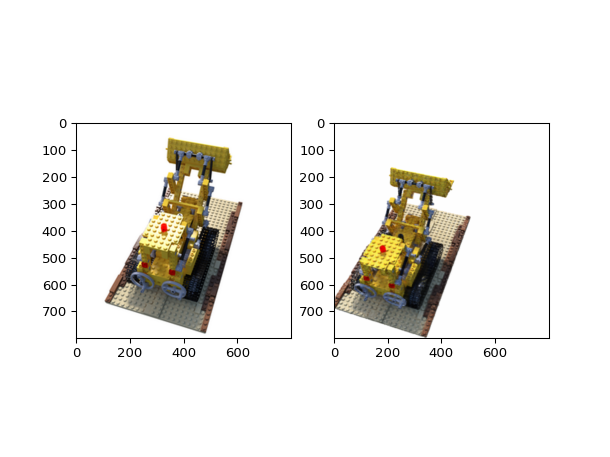

In [231]:
rgb, rgb_map, depth = render_ts_img(ts_dset, 5, model)
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(rgb)
ax[1].imshow(rgb_map)

....................PSNR tensor(25.1480)


<IPython.core.display.Javascript object>


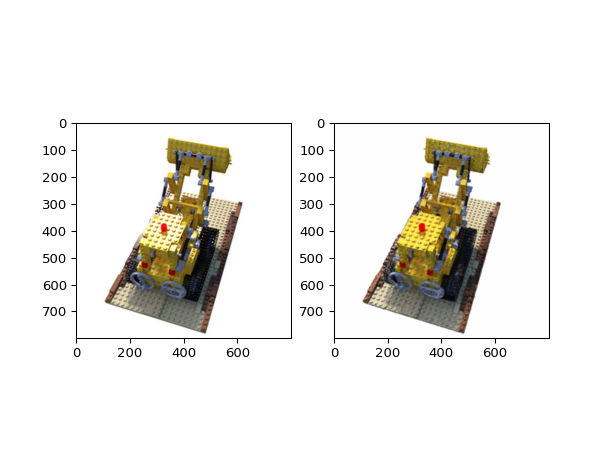

In [183]:
rgb, rgb_map, depth = render_ts_img(ts_dset, 5, model)
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(rgb)
ax[1].imshow(rgb_map)

....................PSNR tensor(18.2437)


<IPython.core.display.Javascript object>


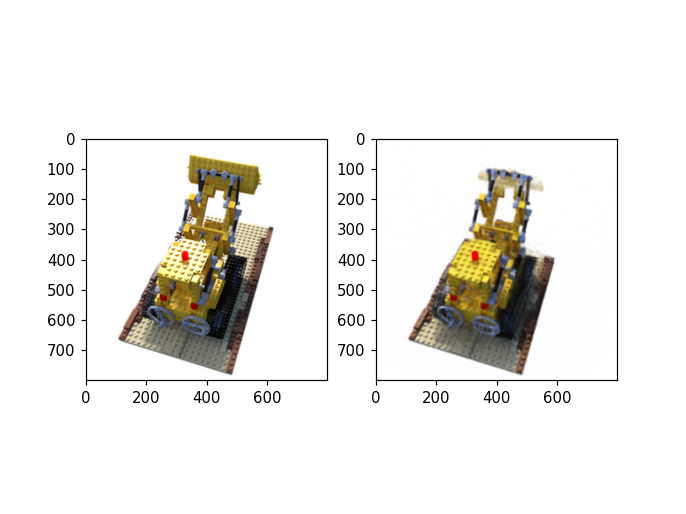

In [64]:
rgb, rgb_map, depth = render_ts_img(ts_dset, 5, model)
# Shrinking second dimension 30-128 no occupancy
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(rgb)
ax[1].imshow(rgb_map)

....................PSNR tensor(24.2801)


<IPython.core.display.Javascript object>


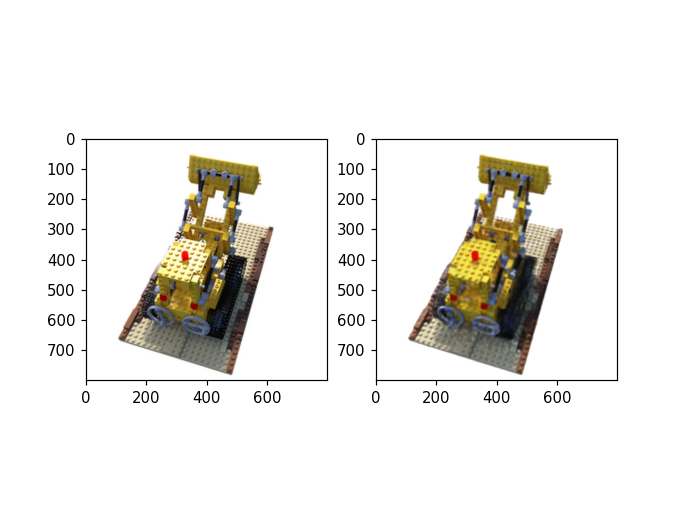

In [56]:
rgb, rgb_map, depth = render_ts_img(ts_dset, 5, model)
# Shrinking second dimension 10-128
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(rgb)
ax[1].imshow(rgb_map)

SHRUNK
tensor([[-0.7916, -1.1693, -0.6609],
        [ 1.0095,  1.2855,  0.7045]])
tensor([124, 169,  94], dtype=torch.int32)
tensor([1.8011, 2.4547, 1.3654])


In [38]:
new_batch = next(iter(tr_loader))
rays, imgs = new_batch
rays_o = rays[:, 0].contiguous()
rays_d = rays[:, 1].contiguous()

In [255]:
_rayso = rays_o[6:7].cpu()
_raysd = rays_d[6:7].cpu()
_rayso, _raysd

(tensor([[-2.7338,  2.8358,  0.8570]]), tensor([[ 0.9727, -0.5013,  0.0578]]))

In [259]:
offsets_pos = (model.aabb[1] - _rayso) / _raysd 
offsets_neg = (model.aabb[0] - _rayso) / _raysd 
offsets_in = torch.minimum(offsets_pos, offsets_neg)  # [batch, 3]
start = torch.amax(offsets_in, dim=-1, keepdim=True)  # [batch, 1]
steps = torch.arange(12).unsqueeze(0)  # [1, n_intrs]
steps = steps.repeat(_raysd.shape[0], 1)   # [batch, n_intrs]
intersections = start + steps * 0.2  # [batch, n_intrs]
intrs_pts = _rayso.unsqueeze(1) + intersections.unsqueeze(2) * _raysd.unsqueeze(1)  # [batch, n_intrs - 1, 3]
intrs_pts = intrs_pts.reshape(-1, 3)
offsets_pos, offsets_neg
print("Intersection points", intrs_pts)
print("Start", start)

Intersection points tensor([[0.2744, 1.2855, 1.0359],
        [0.4689, 1.1852, 1.0474],
        [0.6634, 1.0850, 1.0590],
        [0.8580, 0.9847, 1.0705],
        [1.0525, 0.8845, 1.0821],
        [1.2470, 0.7842, 1.0937],
        [1.4416, 0.6839, 1.1052],
        [1.6361, 0.5837, 1.1168],
        [1.8307, 0.4834, 1.1284],
        [2.0252, 0.3832, 1.1399],
        [2.2197, 0.2829, 1.1515],
        [2.4143, 0.1827, 1.1630]])
Start tensor([[3.0927]])


In [258]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
c = ['k']#, 'r']

ax.scatter(_rayso[:, 0], _rayso[:, 1], _rayso[:, 2], marker='o', c=c)
ax.scatter(_raysd[:, 0], _raysd[:, 1], _raysd[:, 2], marker='x', c=c)
ax.plot([_rayso[0,0], _rayso[0,0] + _raysd[0,0] * 3],
        [_rayso[0,1], _rayso[0,1] + _raysd[0,1] * 3],
        [_rayso[0,2], _rayso[0,2] + _raysd[0,2] * 3])
plot_cube(ax, [
    model.aabb[0], [model.aabb[0,0], model.aabb[1,1], model.aabb[0, 2]],
    [model.aabb[1, 0], model.aabb[0, 1], model.aabb[0, 2]],
    [model.aabb[0, 0], model.aabb[0, 1], model.aabb[1, 2]]])
ax.scatter(intrs_pts[:, 0], intrs_pts[:, 1], intrs_pts[:, 2], marker='.', s=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

<IPython.core.display.Javascript object>

Text(0.5, 0, 'z')

In [61]:
# Render a test image
def render_ts_img(test_dset, test_idx, model, device="cpu"):
    with torch.autograd.no_grad():
        test_el = test_dset[test_idx]
        # These are rays/rgb for a full single image
        rays, rgb = test_el
        rgb = rgb.reshape(test_dset.img_h, test_dset.img_w, 3)
        # We need to do some manual batching
        rgb_map, depth = [], []
        batch_size = 32000
        for b in range(math.ceil(rays.shape[0] / batch_size)):
            rays_o = rays[b * batch_size: (b + 1) * batch_size, 0].contiguous().to(
                device=device)
            rays_d = rays[b * batch_size: (b + 1) * batch_size, 1].contiguous().to(
                device=device)
            rgb_map_b, _, depth_b = model(rays_o=rays_o, rays_d=rays_d)
            rgb_map.append(rgb_map_b.cpu())
            depth.append(depth_b.cpu())
            print('.', end='')
        rgb_map = torch.stack(rgb_map, 0).reshape(test_dset.img_h, test_dset.img_w, 3)
        depth = torch.stack(depth).reshape(test_dset.img_h, test_dset.img_w)

        # Compute loss metrics
        mse = torch.mean((rgb_map - rgb) ** 2)
        psnr = -10.0 * torch.log(mse) / math.log(10)
        print("PSNR", psnr)
    return rgb, rgb_map, depth

In [82]:
large_rgb, large_rgb_map, large_depth = render_ts_img(ts_dset, 5, large_model)

........................................PSNR tensor(25.9352)


In [44]:
rgb, rgb_map, depth = render_ts_img(ts_dset, 5, model)

....................PSNR tensor(24.3901)


In [428]:
m = model

In [429]:
test_el = ts_dset[5]
rays, rgb = test_el
ray_n = 800*500 + 10
_rayso = rays[ray_n:ray_n+1, 0].cpu()
_raysd = rays[ray_n:ray_n+1, 1].cpu()
# _rayso = torch.tensor([[0., 2., 0.]])
# _raysd = torch.tensor([[0., -1., 0.]])
rgb_map_b, _, depth_b = m(rays_o=_rayso, rays_d=_raysd)
print(rgb_map_b)

tensor([[0.5821, 0.5014, 0.4331]], grad_fn=<DifferentiableGraphBackward>)


In [430]:
offsets_pos = (m.aabb[1] - _rayso) / _raysd
offsets_neg = (m.aabb[0] - _rayso) / _raysd
offsets_in = torch.minimum(offsets_pos, offsets_neg)  # [batch, 3]
start = torch.amax(offsets_in, dim=-1, keepdim=True)  # [batch, 1]
steps = torch.arange(12).unsqueeze(0)  # [1, n_intrs]
steps = steps.repeat(_raysd.shape[0], 1)   # [batch, n_intrs]
intersections = start + steps * 0.2  # [batch, n_intrs]
intrs_pts = _rayso.unsqueeze(1) + intersections.unsqueeze(2) * _raysd.unsqueeze(1)  # [batch, n_intrs - 1, 3]
intrs_pts = intrs_pts.reshape(-1, 3)
# offsets_pos, offsets_neg
# print("Intersection points", intrs_pts)
# print("Start", start)

<IPython.core.display.Javascript object>


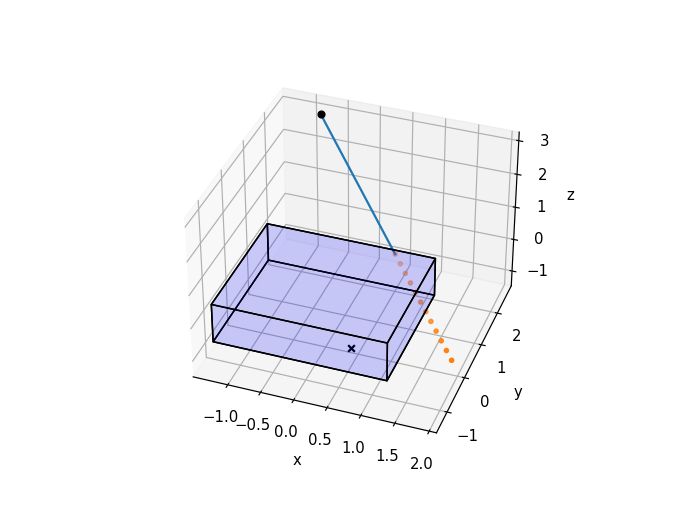

Text(0.5, 0, 'z')

In [431]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
c = ['k']#, 'r']

ax.scatter(_rayso[:, 0], _rayso[:, 1], _rayso[:, 2], marker='o', c=c)
ax.scatter(_raysd[:, 0], _raysd[:, 1], _raysd[:, 2], marker='x', c=c)
ax.plot([_rayso[0,0], _rayso[0,0] + _raysd[0,0] * 3],
        [_rayso[0,1], _rayso[0,1] + _raysd[0,1] * 3],
        [_rayso[0,2], _rayso[0,2] + _raysd[0,2] * 3])
plot_cube(ax, [
    m.aabb[0], [m.aabb[0,0], m.aabb[1,1], m.aabb[0, 2]],
    [m.aabb[1, 0], m.aabb[0, 1], m.aabb[0, 2]],
    [m.aabb[0, 0], m.aabb[0, 1], m.aabb[1, 2]]])
ax.scatter(intrs_pts[:, 0], intrs_pts[:, 1], intrs_pts[:, 2], marker='.', s=30)

# xx, yy = np.meshgrid(np.linspace(-1.3, 1.3, 800), np.linspace(-1.3, 1.3, 800))
# ax.contourf(xx, rgb[:, 0].reshape(800, 800), yy, zdir='y', offset=-1.3, cmap="plasma")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [57]:
preds, _, depth = model(rays_o=rays_o, rays_d=rays_d)
loss = F.mse_loss(preds, imgs)
loss

tensor(0.0656, grad_fn=<MseLossBackward0>)

In [58]:
preds_large, _, depth_large = large_model(rays_o=rays_o, rays_d=rays_d)
loss_large = F.mse_loss(preds_large, imgs)
loss_large

tensor(0.0004, grad_fn=<MseLossBackward0>)

In [60]:
depth

tensor([0.0000, 0.0000, 3.7135,  ..., 0.0000, 4.1857, 0.0000])

In [61]:
depth_large

tensor([0.0000, 0.0669, 3.1690,  ..., 0.0000, 3.8561, 0.0000])

In [5]:
model = tcp.train_grid(cfg)

[autoreload of tc_plenoxel failed: Traceback (most recent call last):
  File "/home/giacomo/anaconda3/envs/torch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/giacomo/anaconda3/envs/torch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/giacomo/anaconda3/envs/torch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/giacomo/anaconda3/envs/torch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/giacomo/anaconda3/envs/torch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/giacomo/anaconda3/envs/torch/lib/python3.8/site-packages/IPython/extensions/autoreload.py", li

Learning rates:  [1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 1461297.7029153437, 10160728.636348171]
Voxel length 1.023e-02 - Num intersections 440


Epoch 0: 1it [00:00,  2.77it/s]

Epoch 0 - iteration 0: MSE 0.0870 PSNR 10.6054


Epoch 0: 205it [00:10, 30.44it/s]

Epoch 0 - iteration 200: MSE 0.0119 PSNR 20.8606


Epoch 0: 403it [00:17, 30.39it/s]

Epoch 0 - iteration 400: MSE 0.0027 PSNR 25.6633


Epoch 0: 604it [00:23, 30.36it/s]

Epoch 0 - iteration 600: MSE 0.0019 PSNR 27.2215


Epoch 0: 802it [00:30, 31.70it/s]

Epoch 0 - iteration 800: MSE 0.0015 PSNR 28.1574


Epoch 0: 906it [00:33, 34.66it/s]

Updated occupancy. Have 7.88% entries full
intr_pts tensor(0.9595, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')



Epoch 0: 910it [00:33, 33.27it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0376, device='cuda:0')
glob_mask tensor(0.0362, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts 

Epoch 0: 919it [00:33, 32.98it/s]

tensor(0.9616, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9651, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')



Epoch 0: 923it [00:34, 32.42it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')


Epoch 0: 932it [00:34, 32.48it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')


Epoch 0: 940it [00:34, 31.15it/s]

intr_pts tensor(0.9649, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')



Epoch 0: 944it [00:34, 32.09it/s]

intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0375, device='cuda:0')
glob_mask tensor(0.0360, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')


Epoch 0: 952it [00:35, 29.20it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0370, device='cuda:0')
glob_mask tensor(0.0356, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')


Epoch 0: 960it [00:35, 31.67it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')



Epoch 0: 964it [00:35, 29.42it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9646, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')


Epoch 0: 972it [00:35, 28.99it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0370, device='cuda:0')
glob_mask tensor(0.0357, device='cuda:0')



Epoch 0: 976it [00:35, 30.82it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')


Epoch 0: 984it [00:36, 30.91it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0370, device='cuda:0')
glob_mask tensor(0.0356, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')


Epoch 0: 992it [00:36, 30.96it/s]

intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts 

Epoch 0: 1000it [00:36, 30.37it/s]

tensor(0.9626, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
No shrinkage possible.



Epoch 0: 1004it [00:36, 32.02it/s]

intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
Epoch 0 - iteration 1000: MSE 0.0013 PSNR 28.7414
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')


Epoch 0: 1012it [00:36, 32.09it/s]

intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0371, device='cuda:0')
glob_mask tensor(0.0357, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')


Epoch 0: 1020it [00:37, 31.69it/s]

intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')



Epoch 0: 1024it [00:37, 30.90it/s]

intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0372, device='cuda:0')
glob_mask tensor(0.0358, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')


Epoch 0: 1032it [00:37, 32.83it/s]

intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0371, device='cuda:0')
glob_mask tensor(0.0357, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts 

Epoch 0: 1040it [00:37, 31.71it/s]

tensor(0.9613, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0370, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')



Epoch 0: 1044it [00:38, 29.95it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')


Epoch 0: 1052it [00:38, 30.63it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0372, device='cuda:0')
glob_mask tensor(0.0357, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0374, device='cuda:0')
glob_mask tensor(0.0359, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts 

Epoch 0: 1060it [00:38, 31.10it/s]

tensor(0.9635, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0374, device='cuda:0')
glob_mask tensor(0.0360, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')


Epoch 0: 1068it [00:38, 32.19it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0370, device='cuda:0')
glob_mask tensor(0.0356, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')



Epoch 0: 1072it [00:38, 28.94it/s]

intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')


Epoch 0: 1080it [00:39, 29.87it/s]

intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')


Epoch 0: 1088it [00:39, 30.50it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')



Epoch 0: 1092it [00:39, 32.33it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0373, device='cuda:0')
glob_mask tensor(0.0358, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')


Epoch 0: 1100it [00:39, 31.48it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0378, device='cuda:0')
glob_mask tensor(0.0364, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')


Epoch 0: 1110it [00:40, 33.95it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')


Epoch 0: 1118it [00:40, 32.79it/s]

intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0370, device='cuda:0')
glob_mask tensor(0.0356, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')



Epoch 0: 1122it [00:40, 33.77it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0371, device='cuda:0')
glob_mask tensor(0.0357, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')


Epoch 0: 1130it [00:40, 31.64it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0378, device='cuda:0')
glob_mask tensor(0.0363, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')


Epoch 0: 1138it [00:40, 31.84it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0374, device='cuda:0')
glob_mask tensor(0.0360, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')



Epoch 0: 1142it [00:41, 30.84it/s]

intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9644, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')


Epoch 0: 1150it [00:41, 31.53it/s]

glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')



Epoch 0: 1154it [00:41, 30.21it/s]

intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')


Epoch 0: 1162it [00:41, 30.66it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')


Epoch 0: 1170it [00:42, 30.01it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')


Epoch 0: 1177it [00:42, 27.73it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')


Epoch 0: 1185it [00:42, 29.00it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')



Epoch 0: 1188it [00:42, 28.36it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0378, device='cuda:0')
glob_mask tensor(0.0364, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')


Epoch 0: 1196it [00:42, 30.47it/s]

intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0375, device='cuda:0')
glob_mask tensor(0.0360, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')


Epoch 0: 1204it [00:43, 27.98it/s]

intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')
Epoch 0 - iteration 1200: MSE 0.0012 PSNR 29.2030
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')


Epoch 0: 1212it [00:43, 28.91it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')



Epoch 0: 1216it [00:43, 30.45it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0373, device='cuda:0')
glob_mask tensor(0.0359, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0378, device='cuda:0')
glob_mask tensor(0.0364, device='cuda:0')


Epoch 0: 1224it [00:43, 30.96it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0373, device='cuda:0')
glob_mask tensor(0.0359, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')


Epoch 0: 1232it [00:44, 31.45it/s]

intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask 

Epoch 0: 1240it [00:44, 30.32it/s]

tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')



Epoch 0: 1245it [00:44, 33.25it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')


Epoch 0: 1253it [00:44, 30.89it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9592, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0375, device='cuda:0')
glob_mask tensor(0.0360, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')


Epoch 0: 1261it [00:45, 31.27it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')



Epoch 0: 1265it [00:45, 29.74it/s]

intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9645, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')


Epoch 0: 1273it [00:45, 29.88it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')



Epoch 0: 1277it [00:45, 27.86it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')


Epoch 0: 1285it [00:45, 29.51it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0378, device='cuda:0')
glob_mask tensor(0.0364, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')


Epoch 0: 1294it [00:46, 30.27it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')



Epoch 0: 1298it [00:46, 32.07it/s]

intr_pts tensor(0.9649, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0370, device='cuda:0')
glob_mask tensor(0.0356, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')


Epoch 0: 1306it [00:46, 32.27it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0373, device='cuda:0')
glob_mask tensor(0.0359, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0378, device='cuda:0')
glob_mask tensor(0.0363, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')


Epoch 0: 1314it [00:46, 32.67it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0374, device='cuda:0')
glob_mask tensor(0.0359, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0371, device='cuda:0')
glob_mask tensor(0.0357, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')


Epoch 0: 1322it [00:47, 33.19it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9580, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')


Epoch 0: 1330it [00:47, 32.04it/s]

intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')



Epoch 0: 1334it [00:47, 33.06it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0373, device='cuda:0')
glob_mask tensor(0.0359, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')


Epoch 0: 1342it [00:47, 32.81it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')


Epoch 0: 1350it [00:47, 32.67it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')


Epoch 0: 1358it [00:48, 31.60it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0378, device='cuda:0')
glob_mask tensor(0.0364, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')


Epoch 0: 1366it [00:48, 31.59it/s]

intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0371, device='cuda:0')
glob_mask tensor(0.0357, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')



Epoch 0: 1370it [00:48, 30.79it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')


Epoch 0: 1378it [00:48, 30.80it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts 


Epoch 0: 1382it [00:48, 30.32it/s]

tensor(0.9603, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')


Epoch 0: 1390it [00:49, 29.08it/s]

intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')



Epoch 0: 1394it [00:49, 30.84it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0371, device='cuda:0')
glob_mask tensor(0.0357, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9645, device='cuda:0') occ_mask tensor(0.0373, device='cuda:0')
glob_mask tensor(0.0360, device='cuda:0')


Epoch 0: 1402it [00:49, 31.24it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
Epoch 0 - iteration 1400: MSE 0.0011 PSNR 29.5736
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')


Epoch 0: 1410it [00:49, 30.41it/s]

intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts 


Epoch 0: 1414it [00:50, 30.08it/s]

tensor(0.9631, device='cuda:0') occ_mask tensor(0.0371, device='cuda:0')
glob_mask tensor(0.0357, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0371, device='cuda:0')
glob_mask tensor(0.0356, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')


Epoch 0: 1422it [00:50, 31.69it/s]

intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')



Epoch 0: 1426it [00:50, 29.90it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')


Epoch 0: 1434it [00:50, 28.47it/s]

intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')



Epoch 0: 1438it [00:50, 30.32it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0377, device='cuda:0')
glob_mask tensor(0.0363, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')


Epoch 0: 1446it [00:51, 30.64it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')


Epoch 0: 1454it [00:51, 31.00it/s]

intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0378, device='cuda:0')
glob_mask tensor(0.0363, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')


Epoch 0: 1462it [00:51, 30.53it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0370, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0356, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0375, device='cuda:0')
glob_mask tensor(0.0361, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')



Epoch 0: 1466it [00:51, 32.09it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')


Epoch 0: 1474it [00:51, 30.56it/s]

intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')


Epoch 0: 1482it [00:52, 30.27it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0372, device='cuda:0')
glob_mask tensor(0.0358, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')



Epoch 0: 1486it [00:52, 30.23it/s]

intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')


Epoch 0: 1494it [00:52, 32.95it/s]

glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')
intr_pts tensor(0.9646, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')


Epoch 0: 1502it [00:52, 32.83it/s]

intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9645, device='cuda:0') occ_mask tensor(0.0372, device='cuda:0')
glob_mask tensor(0.0359, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')


Epoch 0: 1510it [00:53, 32.05it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9590, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')



Epoch 0: 1514it [00:53, 31.29it/s]

intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9656, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9647, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9644, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0356, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')


Epoch 0: 1522it [00:53, 31.65it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')


Epoch 0: 1530it [00:53, 33.92it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0373, device='cuda:0')
glob_mask tensor(0.0359, device='cuda:0')
intr_pts tensor(0.9644, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0356, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')


Epoch 0: 1538it [00:53, 34.19it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9646, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0374, device='cuda:0')
glob_mask tensor(0.0360, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')


Epoch 0: 1546it [00:54, 33.92it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')



Epoch 0: 1550it [00:54, 32.54it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')


Epoch 0: 1558it [00:54, 29.65it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')


Epoch 0: 1566it [00:54, 30.29it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0372, device='cuda:0')
glob_mask tensor(0.0358, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')


Epoch 0: 1574it [00:55, 30.71it/s]

intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')



Epoch 0: 1578it [00:55, 29.52it/s]

intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')


Epoch 0: 1586it [00:55, 29.28it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9644, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')



Epoch 0: 1590it [00:55, 30.81it/s]

intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9647, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')


Epoch 0: 1598it [00:55, 30.70it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0370, device='cuda:0')
glob_mask tensor(0.0356, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0376, device='cuda:0')
glob_mask tensor(0.0362, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask 

Epoch 0: 1606it [00:56, 29.74it/s]

tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
Epoch 0 - iteration 1600: MSE 0.0010 PSNR 29.8919
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask 


Epoch 0: 1610it [00:56, 28.43it/s]

tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9646, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')


Epoch 0: 1618it [00:56, 30.15it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts 


Epoch 0: 1622it [00:56, 29.39it/s]

tensor(0.9639, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0374, device='cuda:0')
glob_mask tensor(0.0360, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')



Epoch 0: 1626it [00:56, 31.13it/s]

intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0370, device='cuda:0')
glob_mask tensor(0.0356, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')


Epoch 0: 1634it [00:57, 30.13it/s]

intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0370, device='cuda:0')
glob_mask tensor(0.0357, device='cuda:0')
intr_pts tensor(0.9643, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0373, device='cuda:0')
glob_mask tensor(0.0359, device='cuda:0')
intr_pts tensor(0.9595, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')


Epoch 0: 1642it [00:57, 31.40it/s]

intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')


Epoch 0: 1650it [00:57, 30.37it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9647, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0383, device='cuda:0')
glob_mask tensor(0.0368, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0372, device='cuda:0')
glob_mask tensor(0.0357, device='cuda:0')



Epoch 0: 1654it [00:57, 29.73it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0373, device='cuda:0')
glob_mask tensor(0.0360, device='cuda:0')


Epoch 0: 1663it [00:58, 29.39it/s]

intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')



Epoch 0: 1667it [00:58, 30.89it/s]

intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')


Epoch 0: 1675it [00:58, 28.14it/s]

intr_pts tensor(0.9644, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts 

Epoch 0: 1683it [00:58, 29.37it/s]

tensor(0.9631, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9597, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts 


Epoch 0: 1687it [00:58, 31.35it/s]

tensor(0.9620, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0377, device='cuda:0')
glob_mask tensor(0.0363, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')


Epoch 0: 1695it [00:59, 30.71it/s]

intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0374, device='cuda:0')
glob_mask tensor(0.0359, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')



Epoch 0: 1699it [00:59, 28.41it/s]

intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')


Epoch 0: 1707it [00:59, 32.03it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0370, device='cuda:0')
glob_mask tensor(0.0356, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9646, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask 

Epoch 0: 1715it [00:59, 30.50it/s]

tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0370, device='cuda:0')
glob_mask tensor(0.0356, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')


Epoch 0: 1723it [01:00, 30.71it/s]

intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0370, device='cuda:0')
glob_mask tensor(0.0356, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0380, device='cuda:0')
glob_mask tensor(0.0365, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')



Epoch 0: 1727it [01:00, 28.91it/s]

intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')


Epoch 0: 1735it [01:00, 29.14it/s]

intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')



Epoch 0: 1739it [01:00, 28.31it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0383, device='cuda:0')
glob_mask tensor(0.0368, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0375, device='cuda:0')
glob_mask tensor(0.0362, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0370, device='cuda:0')
glob_mask tensor(0.0356, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask 

Epoch 0: 1747it [01:00, 28.74it/s]

tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0371, device='cuda:0')
glob_mask tensor(0.0357, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')



Epoch 0: 1750it [01:01, 28.17it/s]

intr_pts tensor(0.9647, device='cuda:0') occ_mask tensor(0.0375, device='cuda:0')
glob_mask tensor(0.0362, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')


Epoch 0: 1759it [01:01, 29.88it/s]

intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0370, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')


Epoch 0: 1767it [01:01, 32.87it/s]

intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')



Epoch 0: 1771it [01:01, 29.22it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')


Epoch 0: 1779it [01:02, 27.58it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts 


Epoch 0: 1783it [01:02, 29.63it/s]

tensor(0.9609, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')


Epoch 0: 1791it [01:02, 30.28it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')



Epoch 0: 1795it [01:02, 27.23it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0372, device='cuda:0')
glob_mask tensor(0.0358, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts 


Epoch 0: 1799it [01:02, 29.55it/s]

tensor(0.9614, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
Epoch 0 - iteration 1800: MSE 0.0010 PSNR 30.1418
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')


Epoch 0: 1808it [01:03, 30.53it/s]

intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')


Epoch 0: 1817it [01:03, 30.79it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0379, device='cuda:0')
glob_mask tensor(0.0364, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')



Epoch 0: 1821it [01:03, 31.21it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9592, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')


Epoch 0: 1829it [01:03, 30.90it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')


Epoch 0: 1837it [01:04, 29.66it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')


Epoch 0: 1845it [01:04, 29.75it/s]

intr_pts tensor(0.9594, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')


Epoch 0: 1853it [01:04, 30.56it/s]

intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')



Epoch 0: 1857it [01:04, 32.35it/s]

intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0370, device='cuda:0')
glob_mask tensor(0.0356, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')


Epoch 0: 1865it [01:04, 32.14it/s]

intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')


Epoch 0: 1873it [01:05, 30.92it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')



Epoch 0: 1877it [01:05, 29.23it/s]

intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')



Epoch 0: 1881it [01:05, 30.95it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0356, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')


Epoch 0: 1889it [01:05, 30.54it/s]

intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0371, device='cuda:0')
glob_mask tensor(0.0357, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')


Epoch 0: 1897it [01:06, 29.45it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')


Epoch 0: 1905it [01:06, 29.00it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0371, device='cuda:0')
glob_mask tensor(0.0358, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')



Epoch 0: 1909it [01:06, 30.99it/s]

intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0372, device='cuda:0')
glob_mask tensor(0.0358, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')


Epoch 0: 1917it [01:06, 27.82it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0371, device='cuda:0')
glob_mask tensor(0.0357, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')


Epoch 0: 1925it [01:06, 30.54it/s]

intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0363, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask 


Epoch 0: 1929it [01:07, 32.09it/s]

tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')


Epoch 0: 1937it [01:07, 31.26it/s]

intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0371, device='cuda:0')
glob_mask tensor(0.0356, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0361, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')



Epoch 0: 1941it [01:07, 26.68it/s]

intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0376, device='cuda:0')
glob_mask tensor(0.0361, device='cuda:0')


Epoch 0: 1949it [01:07, 30.50it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0367, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0350, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0353, device='cuda:0')



Epoch 0: 1953it [01:07, 29.54it/s]

intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0368, device='cuda:0')
glob_mask tensor(0.0354, device='cuda:0')
intr_pts tensor(0.9644, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0369, device='cuda:0')
glob_mask tensor(0.0355, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')


Epoch 0: 1964it [01:08, 29.33it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0359, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0345, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0338, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')



Epoch 0: 1968it [01:08, 30.69it/s]

glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0371, device='cuda:0')
glob_mask tensor(0.0357, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0348, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')


Epoch 0: 1976it [01:08, 30.58it/s]

intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0365, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0370, device='cuda:0')
glob_mask tensor(0.0356, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0372, device='cuda:0')
glob_mask tensor(0.0357, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9597, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')



Epoch 0: 1980it [01:08, 32.27it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0371, device='cuda:0')
glob_mask tensor(0.0357, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0346, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0371, device='cuda:0')
glob_mask tensor(0.0358, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0342, device='cuda:0')


Epoch 0: 1988it [01:09, 30.09it/s]

intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0372, device='cuda:0')
glob_mask tensor(0.0357, device='cuda:0')


Epoch 0: 1996it [01:09, 28.71it/s]

intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0360, device='cuda:0')
glob_mask tensor(0.0347, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0353, device='cuda:0')
glob_mask tensor(0.0340, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0350, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9648, device='cuda:0') occ_mask tensor(0.0373, device='cuda:0')
glob_mask tensor(0.0360, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0366, device='cuda:0')
glob_mask tensor(0.0352, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0362, device='cuda:0')
glob_mask tensor(0.0349, device='cuda:0')



Epoch 0: 2000it [01:09, 26.33it/s]

intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0364, device='cuda:0')
glob_mask tensor(0.0351, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0357, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0358, device='cuda:0')
glob_mask tensor(0.0344, device='cuda:0')
Updated occupancy. Have 6.53% entries full
No shrinkage possible.
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
Epoch 0 - iteration 2000: MSE 0.0009 PSNR 30.3701
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')



Epoch 0: 2004it [01:09, 28.77it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')


Epoch 0: 2012it [01:09, 29.34it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')


Epoch 0: 2020it [01:10, 29.76it/s]

intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 2028it [01:10, 28.12it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')



Epoch 0: 2032it [01:10, 30.09it/s]

intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9648, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')


Epoch 0: 2040it [01:10, 30.50it/s]

intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')


Epoch 0: 2048it [01:11, 31.22it/s]

glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts 


Epoch 0: 2052it [01:11, 32.71it/s]

tensor(0.9611, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0355, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')



Epoch 0: 2056it [01:11, 27.07it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')


Epoch 0: 2064it [01:11, 28.09it/s]

intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')


Epoch 0: 2072it [01:11, 28.95it/s]

intr_pts tensor(0.9646, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')



Epoch 0: 2076it [01:12, 30.55it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')


Epoch 0: 2084it [01:12, 31.35it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9593, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 2092it [01:12, 30.14it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')



Epoch 0: 2096it [01:12, 31.54it/s]

intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')


Epoch 0: 2104it [01:12, 32.11it/s]

glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')


Epoch 0: 2112it [01:13, 31.05it/s]

intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9644, device='cuda:0') occ_mask tensor(0.0354, device='cuda:0')
glob_mask tensor(0.0341, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')



Epoch 0: 2116it [01:13, 29.88it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')


Epoch 0: 2124it [01:13, 32.59it/s]

intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')


Epoch 0: 2132it [01:13, 32.60it/s]

intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')


Epoch 0: 2140it [01:14, 32.26it/s]

intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')



Epoch 0: 2144it [01:14, 30.19it/s]

intr_pts tensor(0.9652, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')



Epoch 0: 2148it [01:14, 30.10it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')


Epoch 0: 2156it [01:14, 30.21it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')


Epoch 0: 2164it [01:14, 29.73it/s]

intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 2172it [01:15, 29.82it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')



Epoch 0: 2176it [01:15, 28.39it/s]

intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')


Epoch 0: 2184it [01:15, 31.82it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask 


Epoch 0: 2188it [01:15, 28.77it/s]

tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9644, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')


Epoch 0: 2196it [01:16, 29.15it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')



Epoch 0: 2200it [01:16, 30.94it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
Epoch 0 - iteration 2200: MSE 0.0009 PSNR 30.5615
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 2211it [01:16, 30.59it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')



Epoch 0: 2215it [01:16, 28.10it/s]

intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')


Epoch 0: 2223it [01:16, 29.32it/s]

intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')



Epoch 0: 2227it [01:17, 31.09it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts 

Epoch 0: 2235it [01:17, 30.40it/s]

tensor(0.9626, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')


Epoch 0: 2243it [01:17, 29.07it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9646, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')


Epoch 0: 2251it [01:17, 28.67it/s]

intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')



Epoch 0: 2255it [01:18, 30.62it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')


Epoch 0: 2263it [01:18, 29.71it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')


Epoch 0: 2271it [01:18, 30.30it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')



Epoch 0: 2275it [01:18, 28.01it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9648, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')


Epoch 0: 2283it [01:18, 32.16it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')


Epoch 0: 2291it [01:19, 30.81it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 2299it [01:19, 31.67it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9643, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')



Epoch 0: 2303it [01:19, 29.12it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')



Epoch 0: 2307it [01:19, 30.08it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9652, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 2315it [01:20, 28.72it/s]

intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0336, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts 


Epoch 0: 2319it [01:20, 30.65it/s]

tensor(0.9639, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')


Epoch 0: 2327it [01:20, 30.32it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0356, device='cuda:0')
glob_mask tensor(0.0343, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')


Epoch 0: 2335it [01:20, 30.23it/s]

intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9643, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')


Epoch 0: 2343it [01:21, 29.15it/s]

intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9647, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')


Epoch 0: 2351it [01:21, 30.66it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')



Epoch 0: 2355it [01:21, 28.71it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')



Epoch 0: 2359it [01:21, 30.53it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9593, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')


Epoch 0: 2367it [01:21, 30.40it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')


Epoch 0: 2375it [01:22, 30.48it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9644, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 2383it [01:22, 30.55it/s]

intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts 


Epoch 0: 2387it [01:22, 32.29it/s]

tensor(0.9606, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')


Epoch 0: 2396it [01:22, 31.28it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9592, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')


Epoch 0: 2404it [01:23, 30.79it/s]

intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9597, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
Epoch 0 - iteration 2400: MSE 0.0008 PSNR 30.7654
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')



Epoch 0: 2408it [01:23, 28.94it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')



Epoch 0: 2413it [01:23, 31.90it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')


Epoch 0: 2421it [01:23, 30.91it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9643, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')


Epoch 0: 2429it [01:23, 32.21it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')



Epoch 0: 2434it [01:24, 29.62it/s]

intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')


Epoch 0: 2443it [01:24, 31.38it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')


Epoch 0: 2451it [01:24, 34.15it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')



Epoch 0: 2455it [01:24, 30.00it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')


Epoch 0: 2463it [01:25, 29.88it/s]

glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')



Epoch 0: 2467it [01:25, 31.11it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask 

Epoch 0: 2476it [01:25, 32.20it/s]

tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0

Epoch 0: 2485it [01:25, 31.11it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts

Epoch 0: 2494it [01:26, 32.11it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0348, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')



Epoch 0: 2498it [01:26, 28.51it/s]

intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9647, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')



Epoch 0: 2502it [01:26, 30.45it/s]

intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask 

Epoch 0: 2510it [01:26, 30.15it/s]

tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')


Epoch 0: 2518it [01:26, 30.26it/s]

intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')



Epoch 0: 2523it [01:26, 33.40it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')


Epoch 0: 2531it [01:27, 31.73it/s]

intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')


Epoch 0: 2539it [01:27, 31.87it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9595, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts


Epoch 0: 2543it [01:27, 30.46it/s]

tensor(0.9613, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')


Epoch 0: 2551it [01:27, 29.43it/s]

intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')



Epoch 0: 2556it [01:28, 32.62it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9645, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')


Epoch 0: 2565it [01:28, 32.66it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')



Epoch 0: 2569it [01:28, 31.08it/s]

intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9646, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')


Epoch 0: 2578it [01:28, 30.87it/s]

intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')



Epoch 0: 2582it [01:28, 32.33it/s]

intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 2590it [01:29, 32.31it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')


Epoch 0: 2599it [01:29, 33.78it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts


Epoch 0: 2603it [01:29, 28.74it/s]

Epoch 0 - iteration 2600: MSE 0.0008 PSNR 30.8921
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')



Epoch 0: 2607it [01:29, 30.96it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')


Epoch 0: 2615it [01:29, 29.53it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 2623it [01:30, 29.00it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')



Epoch 0: 2627it [01:30, 31.06it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts 

Epoch 0: 2635it [01:30, 29.64it/s]

tensor(0.9619, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9595, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts 


Epoch 0: 2639it [01:30, 26.42it/s]

tensor(0.9619, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')



Epoch 0: 2643it [01:30, 28.98it/s]

intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')


Epoch 0: 2651it [01:31, 29.85it/s]

intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')


Epoch 0: 2659it [01:31, 28.77it/s]

intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')


Epoch 0: 2667it [01:31, 28.50it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9592, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')


Epoch 0: 2675it [01:32, 29.52it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')



Epoch 0: 2679it [01:32, 31.46it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')


Epoch 0: 2687it [01:32, 31.66it/s]

intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts


Epoch 0: 2692it [01:32, 29.17it/s]

tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')


Epoch 0: 2700it [01:32, 31.09it/s]

intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')



Epoch 0: 2704it [01:32, 29.55it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')


Epoch 0: 2712it [01:33, 29.85it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')



Epoch 0: 2716it [01:33, 31.60it/s]

intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9592, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')


Epoch 0: 2724it [01:33, 31.67it/s]

intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 2732it [01:33, 31.54it/s]

intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0349, device='cuda:0')
glob_mask tensor(0.0335, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')



Epoch 0: 2737it [01:34, 28.87it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9649, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')


Epoch 0: 2746it [01:34, 31.03it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')



Epoch 0: 2751it [01:34, 33.86it/s]

intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')


Epoch 0: 2759it [01:34, 32.49it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')


Epoch 0: 2767it [01:35, 30.72it/s]

intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')



Epoch 0: 2771it [01:35, 29.06it/s]

intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')


Epoch 0: 2779it [01:35, 28.82it/s]

intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0352, device='cuda:0')
glob_mask tensor(0.0339, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')


Epoch 0: 2787it [01:35, 33.01it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9593, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')


Epoch 0: 2795it [01:35, 30.88it/s]

intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')



Epoch 0: 2799it [01:36, 29.82it/s]

intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0351, device='cuda:0')
glob_mask tensor(0.0337, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
Epoch 0 - iteration 2800: MSE 0.0008 PSNR 31.0441
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')


Epoch 0: 2807it [01:36, 29.82it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')



Epoch 0: 2811it [01:36, 31.72it/s]

intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')


Epoch 0: 2820it [01:36, 33.16it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts

Epoch 0: 2829it [01:37, 32.27it/s]

intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9651, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts

Epoch 0: 2838it [01:37, 32.77it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts

Epoch 0: 2847it [01:37, 33.65it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0346, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts


Epoch 0: 2851it [01:37, 30.64it/s]

tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')


Epoch 0: 2859it [01:37, 33.58it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0333, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')


Epoch 0: 2867it [01:38, 32.44it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')


Epoch 0: 2875it [01:38, 31.88it/s]

intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')



Epoch 0: 2879it [01:38, 31.17it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')


Epoch 0: 2887it [01:38, 30.36it/s]

intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')



Epoch 0: 2892it [01:38, 33.40it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts 

Epoch 0: 2900it [01:39, 32.78it/s]

tensor(0.9619, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')


Epoch 0: 2908it [01:39, 31.13it/s]

intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')



Epoch 0: 2912it [01:39, 33.24it/s]

intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')


Epoch 0: 2921it [01:39, 32.99it/s]

intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')


Epoch 0: 2930it [01:40, 32.72it/s]

intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts


Epoch 0: 2934it [01:40, 31.37it/s]

glob_mask tensor(0.0329, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')



Epoch 0: 2939it [01:40, 33.85it/s]

intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')


Epoch 0: 2947it [01:40, 28.12it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask 


Epoch 0: 2952it [01:40, 31.52it/s]

tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')


Epoch 0: 2960it [01:41, 30.84it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')


Epoch 0: 2968it [01:41, 28.83it/s]

intr_pts tensor(0.9651, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')



Epoch 0: 2972it [01:41, 30.86it/s]

intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')


Epoch 0: 2980it [01:41, 30.35it/s]

intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0331, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')



Epoch 0: 2984it [01:42, 27.69it/s]

intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')



Epoch 0: 2988it [01:42, 30.09it/s]

intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')


Epoch 0: 2996it [01:42, 29.83it/s]

intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')


Epoch 0: 3004it [01:42, 28.81it/s]

intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
Updated occupancy. Have 6.13% entries full
No shrinkage possible.
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
Epoch 0 - iteration 3000: MSE 0.0008 PSNR 31.1578
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')



Epoch 0: 3008it [01:42, 31.19it/s]

intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 3016it [01:43, 31.33it/s]

intr_pts tensor(0.9645, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')


Epoch 0: 3024it [01:43, 31.01it/s]

intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 3032it [01:43, 31.64it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')



Epoch 0: 3037it [01:43, 30.88it/s]

intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask 


Epoch 0: 3041it [01:43, 32.56it/s]

tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')


Epoch 0: 3050it [01:44, 32.08it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9645, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')



Epoch 0: 3055it [01:44, 30.41it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 3064it [01:44, 30.92it/s]

intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')



Epoch 0: 3069it [01:44, 33.89it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 3077it [01:45, 31.95it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9645, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')



Epoch 0: 3081it [01:45, 33.40it/s]

intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 3089it [01:45, 30.26it/s]

intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 3097it [01:45, 29.98it/s]

intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')


Epoch 0: 3105it [01:45, 31.64it/s]

intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9647, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')



Epoch 0: 3109it [01:46, 29.18it/s]

intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 3118it [01:46, 28.53it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9592, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')



Epoch 0: 3123it [01:46, 32.24it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')


Epoch 0: 3131it [01:46, 32.22it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 3139it [01:47, 30.00it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')



Epoch 0: 3143it [01:47, 30.56it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9597, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')


Epoch 0: 3151it [01:47, 28.75it/s]

intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9597, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 3159it [01:47, 32.67it/s]

intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0301, device='cuda:0')
glob_mask tensor(0.0289, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')


Epoch 0: 3168it [01:47, 34.91it/s]

intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts

Epoch 0: 3176it [01:48, 33.14it/s]

intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts

Epoch 0: 3184it [01:48, 32.32it/s]

intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')



Epoch 0: 3188it [01:48, 28.91it/s]

intr_pts tensor(0.9645, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0347, device='cuda:0')
glob_mask tensor(0.0334, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask 


Epoch 0: 3192it [01:48, 30.96it/s]

tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')


Epoch 0: 3204it [01:49, 33.36it/s]

intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
Epoch 0 - iteration 3200: MSE 0.0008 PSNR 31.2532
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')



Epoch 0: 3208it [01:49, 30.85it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 3216it [01:49, 29.12it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')



Epoch 0: 3220it [01:49, 31.31it/s]

intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')


Epoch 0: 3228it [01:49, 31.01it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')


Epoch 0: 3236it [01:50, 29.26it/s]

intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')



Epoch 0: 3240it [01:50, 31.53it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9646, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')


Epoch 0: 3248it [01:50, 31.77it/s]

intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 3256it [01:50, 31.84it/s]

intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')


Epoch 0: 3264it [01:51, 31.05it/s]

intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')



Epoch 0: 3268it [01:51, 25.79it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')


Epoch 0: 3276it [01:51, 30.70it/s]

intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')


Epoch 0: 3284it [01:51, 34.04it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')


Epoch 0: 3292it [01:52, 33.90it/s]

intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')



Epoch 0: 3296it [01:52, 28.25it/s]

intr_pts tensor(0.9643, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')



Epoch 0: 3300it [01:52, 30.67it/s]

intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 3308it [01:52, 31.13it/s]

intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')


Epoch 0: 3316it [01:52, 30.26it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')


Epoch 0: 3324it [01:53, 30.11it/s]

intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts 


Epoch 0: 3329it [01:53, 33.16it/s]

tensor(0.9627, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9590, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')


Epoch 0: 3337it [01:53, 31.73it/s]

intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9653, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')


Epoch 0: 3345it [01:53, 32.70it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')



Epoch 0: 3349it [01:53, 28.29it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts 

Epoch 0: 3357it [01:54, 28.82it/s]

tensor(0.9615, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9595, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9644, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')



Epoch 0: 3361it [01:54, 30.60it/s]

intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask 

Epoch 0: 3369it [01:54, 30.13it/s]

tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9646, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')



Epoch 0: 3373it [01:54, 26.95it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')


Epoch 0: 3381it [01:54, 30.88it/s]

intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9643, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')


Epoch 0: 3389it [01:55, 31.11it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9591, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts 


Epoch 0: 3393it [01:55, 27.94it/s]

tensor(0.9627, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9644, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts 


Epoch 0: 3397it [01:55, 30.09it/s]

tensor(0.9628, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')


Epoch 0: 3405it [01:55, 29.43it/s]

intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
Epoch 0 - iteration 3400: MSE 0.0007 PSNR 31.3822
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')



Epoch 0: 3409it [01:55, 27.89it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')


Epoch 0: 3417it [01:56, 31.62it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')


Epoch 0: 3425it [01:56, 32.19it/s]

glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')


Epoch 0: 3433it [01:56, 31.77it/s]

intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')



Epoch 0: 3437it [01:56, 29.17it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 3445it [01:57, 28.52it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')


Epoch 0: 3453it [01:57, 32.40it/s]

intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')



Epoch 0: 3457it [01:57, 30.51it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 3465it [01:57, 29.21it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask 


Epoch 0: 3469it [01:57, 31.20it/s]

tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask 

Epoch 0: 3477it [01:58, 30.18it/s]

tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')


Epoch 0: 3485it [01:58, 31.02it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9645, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')



Epoch 0: 3489it [01:58, 32.90it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9649, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 3497it [01:58, 30.53it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')


Epoch 0: 3505it [01:59, 31.12it/s]

intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')



Epoch 0: 3509it [01:59, 28.66it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 3517it [01:59, 29.10it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')



Epoch 0: 3521it [01:59, 31.46it/s]

intr_pts tensor(0.9657, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 3530it [01:59, 31.61it/s]

intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')


Epoch 0: 3538it [02:00, 30.30it/s]

intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9594, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')



Epoch 0: 3542it [02:00, 32.25it/s]

intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9647, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')


Epoch 0: 3550it [02:00, 27.58it/s]

intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0302, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')


Epoch 0: 3558it [02:00, 32.19it/s]

intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0301, device='cuda:0')
glob_mask tensor(0.0289, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')



Epoch 0: 3562it [02:00, 30.89it/s]

intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')


Epoch 0: 3571it [02:01, 31.76it/s]

intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')



Epoch 0: 3576it [02:01, 34.84it/s]

intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')


Epoch 0: 3585it [02:01, 34.21it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')


Epoch 0: 3593it [02:01, 31.64it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')


Epoch 0: 3601it [02:02, 34.85it/s]

intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
Epoch 0 


Epoch 0: 3605it [02:02, 31.50it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0302, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0343, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')



Epoch 0: 3609it [02:02, 33.03it/s]

intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')


Epoch 0: 3617it [02:02, 30.67it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')


Epoch 0: 3625it [02:02, 29.13it/s]

intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9645, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')



Epoch 0: 3629it [02:03, 30.82it/s]

glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')


Epoch 0: 3637it [02:03, 30.20it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')


Epoch 0: 3645it [02:03, 33.67it/s]

intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')



Epoch 0: 3649it [02:03, 28.02it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')


Epoch 0: 3657it [02:03, 31.99it/s]

intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9649, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')


Epoch 0: 3665it [02:04, 32.08it/s]

intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')



Epoch 0: 3669it [02:04, 29.76it/s]

intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')



Epoch 0: 3673it [02:04, 31.75it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')


Epoch 0: 3681it [02:04, 30.23it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9653, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')


Epoch 0: 3690it [02:05, 32.60it/s]

intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 3698it [02:05, 32.50it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')



Epoch 0: 3702it [02:05, 33.97it/s]

intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')


Epoch 0: 3710it [02:05, 33.85it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')


Epoch 0: 3718it [02:05, 31.82it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 3726it [02:06, 34.49it/s]

intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')


Epoch 0: 3734it [02:06, 34.74it/s]

intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')



Epoch 0: 3738it [02:06, 33.84it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')


Epoch 0: 3746it [02:06, 29.43it/s]

intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9590, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9646, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')



Epoch 0: 3750it [02:06, 31.82it/s]

intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9594, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')


Epoch 0: 3758it [02:07, 31.19it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')


Epoch 0: 3766it [02:07, 28.80it/s]

intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')



Epoch 0: 3770it [02:07, 31.13it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9643, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')


Epoch 0: 3778it [02:07, 31.79it/s]

intr_pts tensor(0.9647, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')


Epoch 0: 3786it [02:08, 30.88it/s]

intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9647, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')



Epoch 0: 3790it [02:08, 27.76it/s]

intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask 


Epoch 0: 3794it [02:08, 30.29it/s]

tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')


Epoch 0: 3803it [02:08, 28.87it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
Epoch 0 - iteration 3800: MSE 0.0007 PSNR 31.5893
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')


Epoch 0: 3811it [02:08, 32.89it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9597, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 3819it [02:09, 35.50it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')



Epoch 0: 3823it [02:09, 28.87it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 3831it [02:09, 28.34it/s]

intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')



Epoch 0: 3835it [02:09, 25.09it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')


Epoch 0: 3843it [02:10, 30.19it/s]

intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')



Epoch 0: 3847it [02:10, 27.73it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 3855it [02:10, 29.85it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 3863it [02:10, 30.67it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')



Epoch 0: 3867it [02:10, 32.03it/s]

intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9654, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 3875it [02:11, 30.29it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')


Epoch 0: 3883it [02:11, 29.90it/s]

intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')



Epoch 0: 3887it [02:11, 31.95it/s]

intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')


Epoch 0: 3895it [02:11, 32.25it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')


Epoch 0: 3903it [02:12, 31.38it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')



Epoch 0: 3907it [02:12, 30.59it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')


Epoch 0: 3915it [02:12, 32.33it/s]

intr_pts tensor(0.9644, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')


Epoch 0: 3923it [02:12, 32.80it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 3931it [02:12, 32.79it/s]

intr_pts tensor(0.9644, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9644, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9647, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')


Epoch 0: 3939it [02:13, 32.79it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9648, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')


Epoch 0: 3948it [02:13, 34.77it/s]

intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9643, device='cuda:0') occ_mask tensor(0.0344, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')



Epoch 0: 3952it [02:13, 31.48it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 3961it [02:13, 32.84it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')



Epoch 0: 3966it [02:13, 35.62it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 3975it [02:14, 35.64it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')


Epoch 0: 3984it [02:14, 35.03it/s]

intr_pts tensor(0.9644, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')



Epoch 0: 3988it [02:14, 31.02it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')


Epoch 0: 3996it [02:14, 31.14it/s]

intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9647, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask 


Epoch 0: 4000it [02:15, 31.36it/s]

tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
Updated occupancy. Have 5.93% entries full
Shrinking. New aabb: tensor([[-1.2795, -1.3000, -1.3000],
        [ 1.3000,  1.3000,  1.3000]], device='cuda:0') - new resolution tensor([127, 128, 128], device='cuda:0') - XYZ-min tensor([1, 0, 0], device='cuda:0') - XYZ-max tensor([128, 128, 128], device='cuda:0')
Voxel length 1.026e-02 - Num intersections 439
Voxel length 1.023e-02 - Num intersections 439
Upsampling to new resolution (177, 179, 179)
Voxel length 7.303e-03 - Num intersections 615
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
Epoch 0 - iteration 4000: MSE 0.0007 PSNR 31.6384
intr_pts

Epoch 0: 4007it [02:17,  5.88it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 4013it [02:17,  9.17it/s]

intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 4019it [02:18, 13.69it/s]

intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 4025it [02:18, 18.51it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9593, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')


Epoch 0: 4031it [02:18, 22.60it/s]

intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9645, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')


Epoch 0: 4037it [02:18, 25.31it/s]

intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')


Epoch 0: 4043it [02:18, 26.39it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0345, device='cuda:0')
glob_mask tensor(0.0332, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 4049it [02:19, 27.58it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')


Epoch 0: 4055it [02:19, 27.90it/s]

intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9594, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')


Epoch 0: 4061it [02:19, 28.39it/s]

intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0285, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')


Epoch 0: 4067it [02:19, 28.02it/s]

intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9593, device='cuda:0') occ_mask tensor(0.0341, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 4073it [02:20, 28.29it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0282, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 4079it [02:20, 28.39it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 4085it [02:20, 28.60it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')


Epoch 0: 4091it [02:20, 28.22it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9590, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')


Epoch 0: 4097it [02:20, 28.29it/s]

intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 4103it [02:21, 28.75it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9597, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')


Epoch 0: 4109it [02:21, 28.85it/s]

intr_pts tensor(0.9645, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')


Epoch 0: 4115it [02:21, 28.76it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9587, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')


Epoch 0: 4121it [02:21, 28.96it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')


Epoch 0: 4127it [02:21, 28.83it/s]

intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')


Epoch 0: 4134it [02:22, 29.44it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask 

Epoch 0: 4140it [02:22, 29.23it/s]

tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 4146it [02:22, 29.21it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')


Epoch 0: 4152it [02:22, 29.18it/s]

intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')



Epoch 0: 4155it [02:22, 28.96it/s]

intr_pts tensor(0.9645, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 4164it [02:23, 28.61it/s]

intr_pts tensor(0.9588, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')


Epoch 0: 4170it [02:23, 28.76it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')



Epoch 0: 4173it [02:23, 28.66it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 4182it [02:23, 28.92it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')


Epoch 0: 4188it [02:24, 28.98it/s]

intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')


Epoch 0: 4194it [02:24, 28.82it/s]

intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 4200it [02:24, 28.60it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9597, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')



Epoch 0: 4203it [02:24, 28.79it/s]

intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
Epoch 0 - iteration 4200: MSE 0.0022 PSNR 26.8435
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 4209it [02:24, 28.10it/s]

intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')


Epoch 0: 4218it [02:25, 28.70it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')



Epoch 0: 4221it [02:25, 28.72it/s]

intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts 

Epoch 0: 4228it [02:25, 28.99it/s]

tensor(0.9601, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 4234it [02:25, 29.14it/s]

intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')


Epoch 0: 4240it [02:25, 28.82it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9597, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 4246it [02:26, 28.86it/s]

intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9589, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')


Epoch 0: 4252it [02:26, 28.91it/s]

intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')


Epoch 0: 4258it [02:26, 28.86it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9595, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')


Epoch 0: 4264it [02:26, 29.10it/s]

intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')


Epoch 0: 4270it [02:26, 29.05it/s]

intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')


Epoch 0: 4276it [02:27, 28.99it/s]

intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')


Epoch 0: 4282it [02:27, 28.81it/s]

intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9595, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')


Epoch 0: 4288it [02:27, 29.00it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')


Epoch 0: 4294it [02:27, 29.05it/s]

intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 4300it [02:27, 28.94it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 4306it [02:28, 28.96it/s]

intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 4312it [02:28, 29.04it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9588, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts 

Epoch 0: 4318it [02:28, 29.06it/s]

tensor(0.9614, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9643, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 4325it [02:28, 29.65it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask 

Epoch 0: 4332it [02:28, 29.80it/s]

tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts 


Epoch 0: 4335it [02:29, 29.32it/s]

tensor(0.9618, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 4344it [02:29, 28.57it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 4350it [02:29, 28.73it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')


Epoch 0: 4356it [02:29, 28.69it/s]

intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')



Epoch 0: 4359it [02:29, 28.86it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0302, device='cuda:0')
glob_mask tensor(0.0290, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 4368it [02:30, 28.90it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')


Epoch 0: 4374it [02:30, 28.80it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')


Epoch 0: 4380it [02:30, 28.72it/s]

intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 4386it [02:30, 28.88it/s]

intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')



Epoch 0: 4389it [02:30, 28.44it/s]

intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 4395it [02:31, 28.62it/s]

intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')


Epoch 0: 4404it [02:31, 27.78it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
Epoch 0 - iteration 4400: MSE 0.0013 PSNR 28.9500
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')



Epoch 0: 4407it [02:31, 27.86it/s]

intr_pts tensor(0.9597, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')


Epoch 0: 4416it [02:31, 28.50it/s]

intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 4422it [02:32, 28.80it/s]

intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9593, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 4428it [02:32, 29.13it/s]

intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 4434it [02:32, 27.32it/s]

intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')



Epoch 0: 4437it [02:32, 27.65it/s]

intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9592, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 4443it [02:32, 25.98it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 4449it [02:33, 24.94it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')


Epoch 0: 4455it [02:33, 25.38it/s]

intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')



Epoch 0: 4458it [02:33, 25.27it/s]

intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9589, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')


Epoch 0: 4464it [02:33, 26.86it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts 

Epoch 0: 4470it [02:33, 26.19it/s]

tensor(0.9590, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 4476it [02:34, 25.46it/s]

intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')


Epoch 0: 4482it [02:34, 27.08it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')


Epoch 0: 4488it [02:34, 26.24it/s]

intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9647, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 4494it [02:34, 26.43it/s]

intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9597, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 4500it [02:35, 27.96it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts 

Epoch 0: 4506it [02:35, 26.78it/s]

tensor(0.9627, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')



Epoch 0: 4509it [02:35, 27.63it/s]

intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')


Epoch 0: 4515it [02:35, 26.48it/s]

intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 4521it [02:35, 26.85it/s]

intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9592, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')


Epoch 0: 4527it [02:36, 27.91it/s]

intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')


Epoch 0: 4533it [02:36, 27.80it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 4539it [02:36, 26.13it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')



Epoch 0: 4542it [02:36, 26.86it/s]

intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')


Epoch 0: 4551it [02:37, 26.33it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')


Epoch 0: 4557it [02:37, 25.44it/s]

intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')


Epoch 0: 4563it [02:37, 27.02it/s]

intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')



Epoch 0: 4566it [02:37, 27.49it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts 

Epoch 0: 4572it [02:37, 26.64it/s]

tensor(0.9634, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9585, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 4578it [02:38, 27.29it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')


Epoch 0: 4584it [02:38, 26.83it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 4590it [02:38, 25.77it/s]

intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')


Epoch 0: 4596it [02:38, 27.40it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')


Epoch 0: 4602it [02:38, 25.40it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
Epoch 0 - iteration 4600: MSE 0.0011 PSNR 29.6608
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')



Epoch 0: 4605it [02:39, 26.41it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask 

Epoch 0: 4611it [02:39, 26.11it/s]

tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9645, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 4617it [02:39, 23.48it/s]

intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 4623it [02:39, 26.04it/s]

intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')


Epoch 0: 4629it [02:40, 25.85it/s]

intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9650, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')



Epoch 0: 4632it [02:40, 26.68it/s]

intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts 

Epoch 0: 4639it [02:40, 26.29it/s]

tensor(0.9602, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0284, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')


Epoch 0: 4645it [02:40, 26.22it/s]

intr_pts tensor(0.9644, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts 


Epoch 0: 4648it [02:40, 26.84it/s]

tensor(0.9630, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')


Epoch 0: 4657it [02:41, 27.41it/s]

intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')



Epoch 0: 4660it [02:41, 27.33it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')


Epoch 0: 4666it [02:41, 27.99it/s]

intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 4672it [02:41, 26.80it/s]

intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 4678it [02:41, 23.44it/s]

intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')



Epoch 0: 4681it [02:42, 24.73it/s]

intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0342, device='cuda:0')
glob_mask tensor(0.0330, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0339, device='cuda:0')
glob_mask tensor(0.0326, device='cuda:0')


Epoch 0: 4687it [02:42, 26.42it/s]

intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 4696it [02:42, 27.87it/s]

intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9645, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 4702it [02:42, 28.40it/s]

intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')



Epoch 0: 4705it [02:42, 28.51it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 4711it [02:43, 28.77it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask 

Epoch 0: 4718it [02:43, 28.86it/s]

tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')


Epoch 0: 4724it [02:43, 28.80it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9643, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')


Epoch 0: 4730it [02:43, 28.57it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')


Epoch 0: 4737it [02:43, 28.89it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 4743it [02:44, 28.14it/s]

intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')


Epoch 0: 4749it [02:44, 26.65it/s]

intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0321, device='cuda:0')
intr_pts 


Epoch 0: 4752it [02:44, 26.89it/s]

tensor(0.9619, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 4761it [02:44, 26.07it/s]

intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0301, device='cuda:0')
glob_mask tensor(0.0289, device='cuda:0')



Epoch 0: 4765it [02:45, 24.65it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')



Epoch 0: 4769it [02:45, 26.35it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 4775it [02:45, 23.36it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')


Epoch 0: 4781it [02:45, 25.95it/s]

intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0288, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')


Epoch 0: 4787it [02:45, 25.97it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0327, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')


Epoch 0: 4793it [02:46, 25.17it/s]

intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9589, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')


Epoch 0: 4799it [02:46, 26.95it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0302, device='cuda:0')
glob_mask tensor(0.0290, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')



Epoch 0: 4802it [02:46, 24.47it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
Epoch 0 - iteration 4800: MSE 0.0010 PSNR 30.0872
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')


Epoch 0: 4809it [02:46, 27.31it/s]

intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')


Epoch 0: 4815it [02:46, 26.62it/s]

intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9643, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')



Epoch 0: 4818it [02:47, 27.48it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 4824it [02:47, 26.62it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9595, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')


Epoch 0: 4830it [02:47, 26.46it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 4836it [02:47, 27.87it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 4843it [02:48, 28.43it/s]

intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 4849it [02:48, 25.77it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')


Epoch 0: 4855it [02:48, 25.44it/s]

intr_pts tensor(0.9647, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 4861it [02:48, 27.07it/s]

intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9595, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')


Epoch 0: 4867it [02:48, 26.37it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0337, device='cuda:0')
glob_mask tensor(0.0324, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')



Epoch 0: 4870it [02:49, 27.21it/s]

intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 4876it [02:49, 26.33it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9597, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')


Epoch 0: 4882it [02:49, 27.08it/s]

intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')


Epoch 0: 4888it [02:49, 28.04it/s]

intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0333, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')


Epoch 0: 4894it [02:49, 26.97it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9643, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')


Epoch 0: 4900it [02:50, 25.08it/s]

intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 4906it [02:50, 26.82it/s]

intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')


Epoch 0: 4912it [02:50, 25.51it/s]

intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')



Epoch 0: 4916it [02:50, 27.04it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 4922it [02:51, 27.01it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0340, device='cuda:0')
glob_mask tensor(0.0328, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')


Epoch 0: 4928it [02:51, 26.52it/s]

intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 4934it [02:51, 27.62it/s]

intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')


Epoch 0: 4940it [02:51, 27.08it/s]

intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 4946it [02:51, 25.39it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9597, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')


Epoch 0: 4952it [02:52, 26.42it/s]

intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9595, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 4958it [02:52, 27.11it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')


Epoch 0: 4965it [02:52, 26.65it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')



Epoch 0: 4968it [02:52, 27.10it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')


Epoch 0: 4974it [02:52, 26.12it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9595, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')


Epoch 0: 4980it [02:53, 25.06it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')


Epoch 0: 4986it [02:53, 26.83it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')



Epoch 0: 4989it [02:53, 24.96it/s]

intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9597, device='cuda:0') occ_mask tensor(0.0334, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')


Epoch 0: 4995it [02:53, 26.79it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 5001it [02:54, 25.87it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
Updated occupancy. Have 6.06% entries full
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
Epoch 0 - iteration 5000: MSE 0.0009 PSNR 30.3904
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 5007it [02:54, 27.08it/s]

intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')


Epoch 0: 5013it [02:54, 27.96it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')


Epoch 0: 5019it [02:54, 27.90it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0286, device='cuda:0')


Epoch 0: 5025it [02:54, 28.49it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 5031it [02:55, 28.45it/s]

intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0331, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 5037it [02:55, 27.84it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')


Epoch 0: 5043it [02:55, 28.27it/s]

intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 5049it [02:55, 28.73it/s]

intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 5055it [02:55, 28.91it/s]

intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 5061it [02:56, 28.95it/s]

intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 5067it [02:56, 28.69it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')


Epoch 0: 5073it [02:56, 28.81it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0286, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0301, device='cuda:0')
glob_mask tensor(0.0290, device='cuda:0')


Epoch 0: 5079it [02:56, 28.89it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0289, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 5085it [02:56, 29.31it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 5091it [02:57, 29.34it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0288, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts 

Epoch 0: 5098it [02:57, 29.50it/s]

tensor(0.9627, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')


Epoch 0: 5104it [02:57, 29.36it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')


Epoch 0: 5110it [02:57, 29.14it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 5116it [02:58, 28.73it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0287, device='cuda:0')


Epoch 0: 5122it [02:58, 26.56it/s]

intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')


Epoch 0: 5128it [02:58, 27.88it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9597, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9595, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9644, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')



Epoch 0: 5131it [02:58, 26.99it/s]

intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')


Epoch 0: 5137it [02:58, 27.75it/s]

intr_pts tensor(0.9595, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 5143it [02:59, 27.30it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9597, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 5149it [02:59, 27.16it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9643, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')


Epoch 0: 5155it [02:59, 25.24it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9594, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0284, device='cuda:0')


Epoch 0: 5162it [02:59, 27.04it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0288, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0298, device='cuda:0')
glob_mask tensor(0.0286, device='cuda:0')


Epoch 0: 5168it [02:59, 26.40it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')


Epoch 0: 5174it [03:00, 25.75it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9588, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts 

Epoch 0: 5180it [03:00, 27.42it/s]

tensor(0.9602, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')



Epoch 0: 5183it [03:00, 25.92it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0282, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9645, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')


Epoch 0: 5189it [03:00, 27.51it/s]

glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 5196it [03:01, 27.03it/s]

intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0301, device='cuda:0')
glob_mask tensor(0.0290, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')



Epoch 0: 5199it [03:01, 27.67it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
Epoch 0 - iteration 5200: MSE 0.0007 PSNR 31.7776
intr_pts tensor(0.9616, device='cuda:0') occ_mask 

Epoch 0: 5205it [03:01, 26.80it/s]

tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')


Epoch 0: 5211it [03:01, 26.63it/s]

intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')


Epoch 0: 5217it [03:01, 27.89it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')


Epoch 0: 5223it [03:02, 27.40it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts 


Epoch 0: 5227it [03:02, 26.17it/s]

tensor(0.9606, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0338, device='cuda:0')
glob_mask tensor(0.0325, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9643, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 5235it [03:02, 28.75it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9645, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts 

Epoch 0: 5242it [03:02, 28.03it/s]

tensor(0.9649, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')



Epoch 0: 5245it [03:02, 26.21it/s]

intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0298, device='cuda:0')
glob_mask tensor(0.0287, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 5253it [03:03, 27.19it/s]

intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask 

Epoch 0: 5259it [03:03, 27.35it/s]

tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')



Epoch 0: 5262it [03:03, 27.84it/s]

intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0301, device='cuda:0')
glob_mask tensor(0.0289, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts 

Epoch 0: 5269it [03:03, 27.51it/s]

tensor(0.9638, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask 


Epoch 0: 5272it [03:03, 25.01it/s]

tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 5279it [03:04, 27.46it/s]

intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 5285it [03:04, 27.25it/s]

intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')


Epoch 0: 5291it [03:04, 24.63it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')


Epoch 0: 5297it [03:04, 26.81it/s]

intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')


Epoch 0: 5303it [03:05, 27.03it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 5309it [03:05, 26.43it/s]

intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0289, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')


Epoch 0: 5316it [03:05, 28.13it/s]

intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')


Epoch 0: 5322it [03:05, 27.34it/s]

intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')



Epoch 0: 5326it [03:05, 26.79it/s]

intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')


Epoch 0: 5332it [03:06, 27.70it/s]

intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 5338it [03:06, 27.07it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')


Epoch 0: 5344it [03:06, 24.88it/s]

intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0277, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')


Epoch 0: 5350it [03:06, 24.45it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')


Epoch 0: 5356it [03:07, 26.30it/s]

intr_pts tensor(0.9594, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9593, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0298, device='cuda:0')
glob_mask tensor(0.0286, device='cuda:0')


Epoch 0: 5362it [03:07, 26.17it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts 


Epoch 0: 5365it [03:07, 25.00it/s]

tensor(0.9615, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')


Epoch 0: 5371it [03:07, 25.29it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0287, device='cuda:0')
intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 5377it [03:07, 23.24it/s]

intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0301, device='cuda:0')
glob_mask tensor(0.0289, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9644, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts 

Epoch 0: 5383it [03:08, 25.82it/s]

tensor(0.9614, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9650, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9639, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')



Epoch 0: 5386it [03:08, 24.51it/s]

intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 5392it [03:08, 26.49it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9591, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')


Epoch 0: 5398it [03:08, 25.28it/s]

intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0288, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 5404it [03:08, 24.68it/s]

intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
Epoch 0 - iteration 5400: MSE 0.0006 PSNR 32.1470
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 5410it [03:09, 26.72it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')



Epoch 0: 5413it [03:09, 25.18it/s]

intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 5419it [03:09, 25.58it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')


Epoch 0: 5425it [03:09, 24.79it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 5431it [03:10, 24.58it/s]

intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0302, device='cuda:0')
glob_mask tensor(0.0290, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')


Epoch 0: 5437it [03:10, 26.52it/s]

intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9643, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9652, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')



Epoch 0: 5440it [03:10, 24.55it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 5446it [03:10, 26.52it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0285, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask 

Epoch 0: 5452it [03:10, 26.30it/s]

tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0284, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 5458it [03:11, 25.59it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')


Epoch 0: 5464it [03:11, 26.30it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9597, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 5470it [03:11, 26.16it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')



Epoch 0: 5473it [03:11, 26.74it/s]

intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')


Epoch 0: 5479it [03:11, 26.09it/s]

intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9597, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')


Epoch 0: 5485it [03:12, 24.90it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')


Epoch 0: 5491it [03:12, 26.72it/s]

intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0289, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0285, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0302, device='cuda:0')
glob_mask tensor(0.0290, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 5497it [03:12, 26.29it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')



Epoch 0: 5500it [03:12, 27.29it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 5509it [03:12, 27.52it/s]

intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0276, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')



Epoch 0: 5512it [03:13, 27.16it/s]

intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9590, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 5518it [03:13, 27.40it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')


Epoch 0: 5524it [03:13, 26.70it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 5530it [03:13, 26.44it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9647, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0288, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')


Epoch 0: 5536it [03:13, 27.23it/s]

intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0286, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')


Epoch 0: 5542it [03:14, 26.97it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')


Epoch 0: 5548it [03:14, 25.72it/s]

intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')


Epoch 0: 5554it [03:14, 25.96it/s]

intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0301, device='cuda:0')
glob_mask tensor(0.0289, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 5560it [03:14, 26.59it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0275, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')


Epoch 0: 5566it [03:15, 27.68it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0284, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 5572it [03:15, 25.71it/s]

intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9643, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9597, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')


Epoch 0: 5578it [03:15, 27.39it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0289, device='cuda:0')



Epoch 0: 5581it [03:15, 25.37it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 5587it [03:15, 26.91it/s]

intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')


Epoch 0: 5593it [03:16, 25.95it/s]

intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9644, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')


Epoch 0: 5599it [03:16, 25.01it/s]

intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0315, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')


Epoch 0: 5605it [03:16, 27.09it/s]

intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
Epoch 0 - iteration 5600: MSE 0.0006 PSNR 32.4006
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0336, device='cuda:0')
glob_mask tensor(0.0323, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')



Epoch 0: 5608it [03:16, 25.68it/s]

intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9595, device='cuda:0') occ_mask tensor(0.0301, device='cuda:0')
glob_mask tensor(0.0289, device='cuda:0')


Epoch 0: 5614it [03:16, 26.48it/s]

intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 5623it [03:17, 27.39it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9595, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0301, device='cuda:0')
glob_mask tensor(0.0289, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')



Epoch 0: 5626it [03:17, 26.37it/s]

intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')


Epoch 0: 5632it [03:17, 27.41it/s]

intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')


Epoch 0: 5638it [03:17, 25.64it/s]

intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 5644it [03:18, 25.84it/s]

intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask 

Epoch 0: 5650it [03:18, 26.72it/s]

tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')



Epoch 0: 5653it [03:18, 25.32it/s]

intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 5659it [03:18, 26.55it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0302, device='cuda:0')
glob_mask tensor(0.0290, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 5665it [03:18, 25.50it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 5671it [03:19, 24.54it/s]

intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')


Epoch 0: 5677it [03:19, 26.64it/s]

intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9648, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')



Epoch 0: 5680it [03:19, 24.53it/s]

intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0289, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')


Epoch 0: 5688it [03:19, 27.90it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')


Epoch 0: 5695it [03:20, 27.94it/s]

intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')
intr_pts tensor(0.9640, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')



Epoch 0: 5698it [03:20, 26.72it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')


Epoch 0: 5706it [03:20, 28.79it/s]

intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0287, device='cuda:0')


Epoch 0: 5712it [03:20, 27.64it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0320, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0288, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0302, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0301, device='cuda:0')
glob_mask tensor(0.0289, device='cuda:0')


Epoch 0: 5718it [03:20, 26.90it/s]

intr_pts tensor(0.9642, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9646, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')


Epoch 0: 5724it [03:21, 27.89it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0302, device='cuda:0')
glob_mask tensor(0.0290, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts 

Epoch 0: 5730it [03:21, 26.82it/s]

tensor(0.9615, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')


Epoch 0: 5736it [03:21, 26.66it/s]

intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0288, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')



Epoch 0: 5739it [03:21, 27.44it/s]

intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0298, device='cuda:0')
glob_mask tensor(0.0287, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 5748it [03:22, 27.04it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')


Epoch 0: 5754it [03:22, 26.58it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')



Epoch 0: 5757it [03:22, 27.11it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0327, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 5763it [03:22, 24.87it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0332, device='cuda:0')
glob_mask tensor(0.0319, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')


Epoch 0: 5770it [03:22, 27.50it/s]

intr_pts tensor(0.9595, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0285, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask 

Epoch 0: 5776it [03:23, 28.32it/s]

tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0288, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')


Epoch 0: 5782it [03:23, 28.74it/s]

intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0285, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9635, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0329, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')



Epoch 0: 5785it [03:23, 27.07it/s]

intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 5791it [03:23, 28.07it/s]

intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 5797it [03:23, 26.72it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')


Epoch 0: 5803it [03:24, 25.81it/s]

intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
Epoch 0 - iteration 5800: MSE 0.0005 PSNR 32.6744
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts 

Epoch 0: 5809it [03:24, 27.49it/s]

tensor(0.9621, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0284, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')


Epoch 0: 5815it [03:24, 27.65it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9641, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')


Epoch 0: 5821it [03:24, 26.07it/s]

intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9622, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9591, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 5827it [03:24, 27.62it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')



Epoch 0: 5830it [03:25, 25.89it/s]

intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0314, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')


Epoch 0: 5836it [03:25, 27.34it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')


Epoch 0: 5842it [03:25, 27.11it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')



Epoch 0: 5846it [03:25, 28.41it/s]

glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')


Epoch 0: 5855it [03:25, 27.13it/s]

intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')



Epoch 0: 5858it [03:26, 26.14it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0317, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 5864it [03:26, 27.06it/s]

intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0302, device='cuda:0')
glob_mask tensor(0.0290, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0322, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')


Epoch 0: 5870it [03:26, 25.73it/s]

intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9596, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0301, device='cuda:0')
glob_mask tensor(0.0289, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')


Epoch 0: 5876it [03:26, 26.32it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0301, device='cuda:0')
glob_mask tensor(0.0289, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 5882it [03:27, 27.66it/s]

intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0287, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts 

Epoch 0: 5888it [03:27, 26.95it/s]

tensor(0.9630, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0302, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9598, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0310, device='cuda:0')
intr_pts tensor(0.9631, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')


Epoch 0: 5894it [03:27, 27.01it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 5900it [03:27, 27.83it/s]

intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')


Epoch 0: 5906it [03:27, 25.85it/s]

intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0326, device='cuda:0')
glob_mask tensor(0.0313, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0289, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')



Epoch 0: 5909it [03:28, 26.70it/s]

intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')


Epoch 0: 5918it [03:28, 26.16it/s]

intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')



Epoch 0: 5921it [03:28, 23.90it/s]

intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9628, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9638, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')


Epoch 0: 5927it [03:28, 25.05it/s]

intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0335, device='cuda:0')
glob_mask tensor(0.0322, device='cuda:0')
intr_pts tensor(0.9601, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')


Epoch 0: 5933it [03:29, 24.67it/s]

intr_pts tensor(0.9636, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9604, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 5939it [03:29, 25.35it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0315, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9615, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9623, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9629, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')



Epoch 0: 5942it [03:29, 26.44it/s]

intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9603, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9617, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')


Epoch 0: 5948it [03:29, 24.99it/s]

intr_pts tensor(0.9634, device='cuda:0') occ_mask tensor(0.0328, device='cuda:0')
glob_mask tensor(0.0316, device='cuda:0')
intr_pts tensor(0.9606, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9619, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9632, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')


Epoch 0: 5955it [03:29, 23.38it/s]

intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0299, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')


Epoch 0: 5962it [03:30, 23.84it/s]

intr_pts tensor(0.9607, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9643, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9612, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0292, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0324, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9624, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0297, device='cuda:0')


Epoch 0: 5968it [03:30, 26.25it/s]

intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0284, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9593, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
intr_pts tensor(0.9602, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')


Epoch 0: 5974it [03:30, 26.12it/s]

intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0301, device='cuda:0')
glob_mask tensor(0.0289, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0318, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9610, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9613, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0306, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask 


Epoch 0: 5977it [03:30, 26.69it/s]

tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9630, device='cuda:0') occ_mask tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0303, device='cuda:0')
intr_pts tensor(0.9609, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9611, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts 

Epoch 0: 5983it [03:31, 25.17it/s]

tensor(0.9631, device='cuda:0') occ_mask tensor(0.0302, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')
intr_pts tensor(0.9614, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')
intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0295, device='cuda:0')
intr_pts tensor(0.9626, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0291, device='cuda:0')
intr_pts tensor(0.9608, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0301, device='cuda:0')



Epoch 0: 5987it [03:31, 27.09it/s]

intr_pts tensor(0.9616, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0298, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0308, device='cuda:0')
intr_pts tensor(0.9637, device='cuda:0') occ_mask tensor(0.0330, device='cuda:0')
glob_mask tensor(0.0318, device='cuda:0')
intr_pts tensor(0.9594, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0296, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask 

Epoch 0: 5994it [03:31, 25.77it/s]

tensor(0.0314, device='cuda:0')
glob_mask tensor(0.0302, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0323, device='cuda:0')
glob_mask tensor(0.0311, device='cuda:0')
intr_pts tensor(0.9633, device='cuda:0') occ_mask tensor(0.0321, device='cuda:0')
glob_mask tensor(0.0309, device='cuda:0')
intr_pts tensor(0.9618, device='cuda:0') occ_mask tensor(0.0312, device='cuda:0')
glob_mask tensor(0.0300, device='cuda:0')
intr_pts tensor(0.9605, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0305, device='cuda:0')
intr_pts tensor(0.9621, device='cuda:0') occ_mask tensor(0.0320, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')
intr_pts tensor(0.9625, device='cuda:0') occ_mask tensor(0.0319, device='cuda:0')
glob_mask tensor(0.0307, device='cuda:0')



Epoch 0: 5998it [03:31, 25.22it/s]

intr_pts tensor(0.9627, device='cuda:0') occ_mask tensor(0.0316, device='cuda:0')
glob_mask tensor(0.0304, device='cuda:0')
intr_pts tensor(0.9620, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0293, device='cuda:0')
intr_pts tensor(0.9599, device='cuda:0') occ_mask tensor(0.0325, device='cuda:0')
glob_mask tensor(0.0312, device='cuda:0')
intr_pts tensor(0.9600, device='cuda:0') occ_mask tensor(0.0306, device='cuda:0')
glob_mask tensor(0.0294, device='cuda:0')
Updated occupancy. Have 5.87% entries full
Shrinking. New aabb: tensor([[-0.8691, -0.8034, -1.3000],
        [ 1.1827,  0.6865,  1.2854]], device='cuda:0') - new resolution tensor([141, 103, 178], device='cuda:0') - XYZ-min tensor([28, 34,  0], device='cuda:0') - XYZ-max tensor([169, 137, 178], device='cuda:0')
Voxel length 9.764e-03 - Num intersections 460
Voxel length 7.301e-03 - Num intersections 496
intr_pts tensor(0.9274, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tenso

Epoch 0: 6007it [03:34,  6.87it/s]

intr_pts tensor(0.9272, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9270, device='cuda:0') occ_mask tensor(0.0273, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.9288, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9286, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9283, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9280, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9263, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9293, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts

Epoch 0: 6017it [03:34, 12.84it/s]

intr_pts tensor(0.9273, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')
intr_pts tensor(0.9285, device='cuda:0') occ_mask tensor(0.0275, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.9271, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9278, device='cuda:0') occ_mask tensor(0.0275, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.9256, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9266, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9300, device='cuda:0') occ_mask tensor(0.0275, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.9265, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts

Epoch 0: 6026it [03:34, 19.64it/s]

intr_pts tensor(0.9301, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9284, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.9291, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0269, device='cuda:0')
intr_pts tensor(0.9266, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0269, device='cuda:0')
intr_pts tensor(0.9278, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9264, device='cuda:0') occ_mask tensor(0.0273, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.9335, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9284, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0264, device='cuda:0')


Epoch 0: 6036it [03:34, 27.10it/s]

intr_pts tensor(0.9304, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9259, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.9261, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9238, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9303, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0278, device='cuda:0')
intr_pts tensor(0.9269, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')
intr_pts tensor(0.9299, device='cuda:0') occ_mask tensor(0.0271, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.9268, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts

Epoch 0: 6045it [03:35, 32.14it/s]

intr_pts tensor(0.9283, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0268, device='cuda:0')
intr_pts tensor(0.9287, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')
intr_pts tensor(0.9268, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9274, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9276, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9300, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9294, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9296, device='cuda:0') occ_mask tensor(0.0275, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts


Epoch 0: 6050it [03:35, 34.48it/s]

tensor(0.9269, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9249, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')
intr_pts tensor(0.9258, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9320, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0264, device='cuda:0')
intr_pts tensor(0.9304, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9263, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9269, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0268, device='cuda:0')
intr_pts tensor(0.9298, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0

Epoch 0: 6060it [03:35, 37.42it/s]

intr_pts tensor(0.9254, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9292, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0264, device='cuda:0')
intr_pts tensor(0.9268, device='cuda:0') occ_mask tensor(0.0269, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.9287, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0272, device='cuda:0')
intr_pts tensor(0.9277, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9275, device='cuda:0') occ_mask tensor(0.0274, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')
intr_pts tensor(0.9324, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9308, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts


Epoch 0: 6065it [03:35, 38.30it/s]

tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9270, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9278, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0276, device='cuda:0')
intr_pts tensor(0.9273, device='cuda:0') occ_mask tensor(0.0270, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(0.9264, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0271, device='cuda:0')



Epoch 0: 6070it [03:35, 30.56it/s]

intr_pts tensor(0.9295, device='cuda:0') occ_mask tensor(0.0274, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.9289, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9303, device='cuda:0') occ_mask tensor(0.0274, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.9282, device='cuda:0') occ_mask tensor(0.0271, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(0.9313, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0269, device='cuda:0')
intr_pts tensor(0.9272, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')


Epoch 0: 6079it [03:36, 26.77it/s]

intr_pts tensor(0.9300, device='cuda:0') occ_mask tensor(0.0270, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(0.9303, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9262, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9296, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9310, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9298, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')



Epoch 0: 6082it [03:36, 26.21it/s]

intr_pts tensor(0.9292, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9299, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9244, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.9305, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9315, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9301, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9283, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')


Epoch 0: 6089it [03:36, 24.05it/s]

intr_pts tensor(0.9257, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0270, device='cuda:0')
intr_pts tensor(0.9298, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.9304, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0270, device='cuda:0')
intr_pts tensor(0.9291, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9251, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')


Epoch 0: 6097it [03:36, 27.97it/s]

intr_pts tensor(0.9263, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9249, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9274, device='cuda:0') occ_mask tensor(0.0269, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.9256, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9294, device='cuda:0') occ_mask tensor(0.0269, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.9302, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0269, device='cuda:0')


Epoch 0: 6105it [03:37, 30.88it/s]

intr_pts tensor(0.9299, device='cuda:0') occ_mask tensor(0.0271, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.9296, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0276, device='cuda:0')
intr_pts tensor(0.9297, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0268, device='cuda:0')
intr_pts tensor(0.9308, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9298, device='cuda:0') occ_mask tensor(0.0275, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.9244, device='cuda:0') occ_mask tensor(0.0259, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')
intr_pts tensor(0.9269, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9286, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')



Epoch 0: 6109it [03:37, 29.24it/s]

intr_pts tensor(0.9292, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')
intr_pts tensor(0.9307, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9295, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9277, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0272, device='cuda:0')
intr_pts tensor(0.9307, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9294, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0274, device='cuda:0')
intr_pts tensor(0.9288, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0271, device='cuda:0')
intr_pts tensor(0.9277, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')


Epoch 0: 6118it [03:37, 30.63it/s]

intr_pts tensor(0.9271, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9269, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9250, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9265, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9272, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0271, device='cuda:0')
intr_pts tensor(0.9313, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0270, device='cuda:0')



Epoch 0: 6122it [03:37, 32.77it/s]

intr_pts tensor(0.9274, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')
intr_pts tensor(0.9275, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.9322, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0275, device='cuda:0')
intr_pts tensor(0.9272, device='cuda:0') occ_mask tensor(0.0273, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.9278, device='cuda:0') occ_mask tensor(0.0274, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')
intr_pts tensor(0.9290, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0270, device='cuda:0')


Epoch 0: 6130it [03:37, 31.67it/s]

intr_pts tensor(0.9255, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9268, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0269, device='cuda:0')
intr_pts tensor(0.9292, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9267, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9272, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9295, device='cuda:0') occ_mask tensor(0.0269, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.9269, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0270, device='cuda:0')


Epoch 0: 6138it [03:38, 31.23it/s]

intr_pts tensor(0.9266, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.9303, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9297, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9314, device='cuda:0') occ_mask tensor(0.0265, device='cuda:0')
glob_mask tensor(0.0246, device='cuda:0')
intr_pts tensor(0.9261, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9276, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')



Epoch 0: 6142it [03:38, 27.21it/s]

intr_pts tensor(0.9290, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9312, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9289, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9320, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9298, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0264, device='cuda:0')
intr_pts tensor(0.9314, device='cuda:0') occ_mask tensor(0.0267, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')
intr_pts 


Epoch 0: 6146it [03:38, 29.66it/s]

tensor(0.9269, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9300, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9300, device='cuda:0') occ_mask tensor(0.0268, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')
intr_pts tensor(0.9333, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0274, device='cuda:0')
intr_pts tensor(0.9299, device='cuda:0') occ_mask tensor(0.0273, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')


Epoch 0: 6154it [03:38, 26.91it/s]

intr_pts tensor(0.9303, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')
intr_pts tensor(0.9256, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0272, device='cuda:0')
intr_pts tensor(0.9298, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0271, device='cuda:0')
intr_pts tensor(0.9263, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9295, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0269, device='cuda:0')
intr_pts tensor(0.9285, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9269, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')


Epoch 0: 6161it [03:39, 27.45it/s]

intr_pts tensor(0.9273, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9268, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9282, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9302, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0276, device='cuda:0')
intr_pts tensor(0.9267, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0269, device='cuda:0')
intr_pts tensor(0.9267, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9260, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')



Epoch 0: 6165it [03:39, 30.07it/s]

intr_pts tensor(0.9257, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9273, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0274, device='cuda:0')
intr_pts tensor(0.9283, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0268, device='cuda:0')
intr_pts tensor(0.9270, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9310, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9294, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')


Epoch 0: 6173it [03:39, 30.59it/s]

intr_pts tensor(0.9238, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.9273, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9302, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9301, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9257, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0268, device='cuda:0')
intr_pts tensor(0.9298, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0270, device='cuda:0')
intr_pts tensor(0.9270, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0264, device='cuda:0')


Epoch 0: 6181it [03:39, 29.13it/s]

intr_pts tensor(0.9298, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9260, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0268, device='cuda:0')
intr_pts tensor(0.9277, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9287, device='cuda:0') occ_mask tensor(0.0270, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.9306, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0276, device='cuda:0')
intr_pts tensor(0.9270, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0273, device='cuda:0')
intr_pts tensor(0.9320, device='cuda:0') occ_mask tensor(0.0271, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')


Epoch 0: 6188it [03:39, 27.87it/s]

intr_pts tensor(0.9283, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.9301, device='cuda:0') occ_mask tensor(0.0298, device='cuda:0')
glob_mask tensor(0.0277, device='cuda:0')
intr_pts tensor(0.9262, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0268, device='cuda:0')
intr_pts tensor(0.9277, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9273, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9249, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0269, device='cuda:0')



Epoch 0: 6192it [03:40, 30.53it/s]

intr_pts tensor(0.9315, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0275, device='cuda:0')
intr_pts tensor(0.9289, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.9298, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0272, device='cuda:0')
intr_pts tensor(0.9277, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9232, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0273, device='cuda:0')
intr_pts tensor(0.9300, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')


Epoch 0: 6200it [03:40, 30.57it/s]

intr_pts tensor(0.9268, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')
intr_pts tensor(0.9281, device='cuda:0') occ_mask tensor(0.0271, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.9277, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9290, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9290, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9276, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
Epoch 0 - iteration 6200: MSE 0.0529 PSNR 12.7809
intr_pts tensor(0.9278, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')


Epoch 0: 6208it [03:40, 30.93it/s]

intr_pts tensor(0.9262, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0268, device='cuda:0')
intr_pts tensor(0.9282, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')
intr_pts tensor(0.9255, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9300, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9296, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0281, device='cuda:0')
intr_pts tensor(0.9292, device='cuda:0') occ_mask tensor(0.0261, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.9251, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0271, device='cuda:0')



Epoch 0: 6212it [03:40, 29.08it/s]

intr_pts tensor(0.9288, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9267, device='cuda:0') occ_mask tensor(0.0270, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.9272, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9265, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9291, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0282, device='cuda:0')
intr_pts tensor(0.9257, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')


Epoch 0: 6220it [03:40, 30.67it/s]

intr_pts tensor(0.9296, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')
intr_pts tensor(0.9265, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9299, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9264, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0277, device='cuda:0')
intr_pts tensor(0.9299, device='cuda:0') occ_mask tensor(0.0274, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.9275, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.9305, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')


Epoch 0: 6228it [03:41, 33.54it/s]

intr_pts tensor(0.9281, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9294, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9283, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')
intr_pts tensor(0.9242, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9290, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0271, device='cuda:0')
intr_pts tensor(0.9310, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9260, device='cuda:0') occ_mask tensor(0.0268, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')


Epoch 0: 6237it [03:41, 34.38it/s]

intr_pts tensor(0.9259, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9276, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0272, device='cuda:0')
intr_pts tensor(0.9303, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9304, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9295, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9267, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9283, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9288, device='cuda:0') occ_mask tensor(0.0266, device='cuda:0')
glob_mask tensor(0.0247, device='cuda:0')



Epoch 0: 6241it [03:41, 30.07it/s]

intr_pts tensor(0.9285, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0272, device='cuda:0')
intr_pts tensor(0.9278, device='cuda:0') occ_mask tensor(0.0264, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.9269, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0274, device='cuda:0')
intr_pts tensor(0.9285, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9307, device='cuda:0') occ_mask tensor(0.0274, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.9293, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9273, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9256, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0278, device='cuda:0')


Epoch 0: 6250it [03:41, 31.07it/s]

intr_pts tensor(0.9290, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.9278, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9252, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9274, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9242, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9307, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9282, device='cuda:0') occ_mask 


Epoch 0: 6254it [03:42, 32.98it/s]

tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9283, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9271, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9287, device='cuda:0') occ_mask tensor(0.0268, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')
intr_pts tensor(0.9276, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9256, device='cuda:0') occ_mask tensor(0.0270, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')


Epoch 0: 6262it [03:42, 31.59it/s]

intr_pts tensor(0.9289, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9309, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9287, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9280, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9278, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9268, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9271, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')


Epoch 0: 6270it [03:42, 31.41it/s]

intr_pts tensor(0.9272, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9265, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9265, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9303, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9261, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.9263, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9259, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9288, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')


Epoch 0: 6278it [03:42, 31.80it/s]

intr_pts tensor(0.9272, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9262, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0271, device='cuda:0')
intr_pts tensor(0.9245, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9274, device='cuda:0') occ_mask tensor(0.0274, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')
intr_pts tensor(0.9275, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9277, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0269, device='cuda:0')
intr_pts 


Epoch 0: 6282it [03:42, 33.71it/s]

tensor(0.9296, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9298, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9290, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0264, device='cuda:0')
intr_pts tensor(0.9286, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9280, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9282, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0264, device='cuda:0')


Epoch 0: 6291it [03:43, 33.00it/s]

intr_pts tensor(0.9280, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9296, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9280, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0272, device='cuda:0')
intr_pts tensor(0.9270, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9269, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0270, device='cuda:0')
intr_pts tensor(0.9277, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0275, device='cuda:0')
intr_pts tensor(0.9252, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')



Epoch 0: 6295it [03:43, 30.67it/s]

intr_pts tensor(0.9271, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0269, device='cuda:0')
intr_pts tensor(0.9285, device='cuda:0') occ_mask tensor(0.0273, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')
intr_pts tensor(0.9259, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.9272, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9254, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9281, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9274, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9316, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')


Epoch 0: 6303it [03:43, 31.23it/s]

intr_pts tensor(0.9280, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.9277, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9283, device='cuda:0') occ_mask tensor(0.0298, device='cuda:0')
glob_mask tensor(0.0277, device='cuda:0')
intr_pts tensor(0.9262, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0264, device='cuda:0')
intr_pts tensor(0.9264, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9257, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9286, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0269, device='cuda:0')


Epoch 0: 6311it [03:43, 31.91it/s]

intr_pts tensor(0.9237, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9277, device='cuda:0') occ_mask tensor(0.0273, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.9306, device='cuda:0') occ_mask tensor(0.0267, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts tensor(0.9267, device='cuda:0') occ_mask tensor(0.0269, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')
intr_pts tensor(0.9276, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9294, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9278, device='cuda:0') occ_mask tensor(0.0263, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')



Epoch 0: 6316it [03:43, 34.58it/s]

intr_pts tensor(0.9277, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.9280, device='cuda:0') occ_mask tensor(0.0298, device='cuda:0')
glob_mask tensor(0.0277, device='cuda:0')
intr_pts tensor(0.9262, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9255, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9265, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')
intr_pts tensor(0.9289, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')
intr_pts tensor(0.9288, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')


Epoch 0: 6324it [03:44, 34.29it/s]

intr_pts tensor(0.9287, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9251, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9257, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9312, device='cuda:0') occ_mask tensor(0.0260, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.9264, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')
intr_pts tensor(0.9263, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0264, device='cuda:0')
intr_pts tensor(0.9277, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')


Epoch 0: 6332it [03:44, 33.63it/s]

intr_pts tensor(0.9282, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9290, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0273, device='cuda:0')
intr_pts tensor(0.9298, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9293, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9294, device='cuda:0') occ_mask tensor(0.0273, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')
intr_pts tensor(0.9304, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9295, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9305, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')


Epoch 0: 6341it [03:44, 33.45it/s]

intr_pts tensor(0.9265, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9281, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0264, device='cuda:0')
intr_pts tensor(0.9272, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9281, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0264, device='cuda:0')
intr_pts tensor(0.9300, device='cuda:0') occ_mask tensor(0.0275, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.9274, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9287, device='cuda:0') occ_mask 


Epoch 0: 6345it [03:44, 30.22it/s]

tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9252, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9305, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9287, device='cuda:0') occ_mask tensor(0.0273, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.9266, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9317, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')


Epoch 0: 6353it [03:45, 30.95it/s]

intr_pts tensor(0.9277, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0272, device='cuda:0')
intr_pts tensor(0.9268, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.9297, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9277, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0264, device='cuda:0')
intr_pts tensor(0.9269, device='cuda:0') occ_mask tensor(0.0265, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.9289, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')



Epoch 0: 6357it [03:45, 30.74it/s]

intr_pts tensor(0.9317, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0269, device='cuda:0')
intr_pts tensor(0.9304, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.9268, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9279, device='cuda:0') occ_mask tensor(0.0298, device='cuda:0')
glob_mask tensor(0.0276, device='cuda:0')
intr_pts tensor(0.9281, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0274, device='cuda:0')
intr_pts tensor(0.9297, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9311, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0272, device='cuda:0')
intr_pts tensor(0.9305, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0276, device='cuda:0')
intr_pts

Epoch 0: 6367it [03:45, 34.63it/s]

intr_pts tensor(0.9258, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0264, device='cuda:0')
intr_pts tensor(0.9276, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9298, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9254, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9278, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0264, device='cuda:0')
intr_pts tensor(0.9275, device='cuda:0') occ_mask tensor(0.0266, device='cuda:0')
glob_mask tensor(0.0246, device='cuda:0')
intr_pts tensor(0.9269, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0270, device='cuda:0')



Epoch 0: 6371it [03:45, 27.71it/s]

intr_pts tensor(0.9294, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.9266, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0274, device='cuda:0')
intr_pts tensor(0.9287, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9283, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.9300, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')


Epoch 0: 6379it [03:46, 28.73it/s]

intr_pts tensor(0.9287, device='cuda:0') occ_mask tensor(0.0264, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.9268, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0271, device='cuda:0')
intr_pts tensor(0.9304, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0269, device='cuda:0')
intr_pts tensor(0.9311, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9303, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')
intr_pts tensor(0.9286, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0271, device='cuda:0')


Epoch 0: 6387it [03:46, 30.52it/s]

intr_pts tensor(0.9292, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.9298, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9304, device='cuda:0') occ_mask tensor(0.0271, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.9315, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0272, device='cuda:0')
intr_pts tensor(0.9276, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9298, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9284, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')



Epoch 0: 6391it [03:46, 27.41it/s]

intr_pts tensor(0.9300, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9302, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9280, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9271, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9277, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9309, device='cuda:0') occ_mask tensor(0.0274, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.9311, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9246, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')


Epoch 0: 6400it [03:46, 28.22it/s]

intr_pts tensor(0.9279, device='cuda:0') occ_mask tensor(0.0267, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts tensor(0.9289, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9273, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9283, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0276, device='cuda:0')
intr_pts tensor(0.9269, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9322, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0269, device='cuda:0')



Epoch 0: 6404it [03:46, 30.60it/s]

Epoch 0 - iteration 6400: MSE 0.0474 PSNR 13.2431
intr_pts tensor(0.9295, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9280, device='cuda:0') occ_mask tensor(0.0271, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(0.9309, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0275, device='cuda:0')
intr_pts tensor(0.9299, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9270, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')


Epoch 0: 6412it [03:47, 30.27it/s]

intr_pts tensor(0.9280, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9294, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9294, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')
intr_pts tensor(0.9263, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9307, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9287, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.9306, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9258, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')


Epoch 0: 6420it [03:47, 30.26it/s]

intr_pts tensor(0.9252, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9268, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.9275, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9277, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9297, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9272, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9304, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')
intr_pts tensor(0.9269, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')



Epoch 0: 6424it [03:47, 28.59it/s]

intr_pts tensor(0.9298, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9286, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9256, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9300, device='cuda:0') occ_mask tensor(0.0273, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')


Epoch 0: 6431it [03:47, 29.43it/s]

intr_pts tensor(0.9256, device='cuda:0') occ_mask tensor(0.0274, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.9275, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0271, device='cuda:0')
intr_pts tensor(0.9299, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9292, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9286, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0271, device='cuda:0')
intr_pts tensor(0.9285, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')


Epoch 0: 6439it [03:48, 29.22it/s]

intr_pts tensor(0.9275, device='cuda:0') occ_mask tensor(0.0273, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.9260, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0269, device='cuda:0')
intr_pts tensor(0.9271, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.9280, device='cuda:0') occ_mask tensor(0.0270, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.9251, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0273, device='cuda:0')
intr_pts tensor(0.9270, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.9258, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')



Epoch 0: 6443it [03:48, 29.26it/s]

intr_pts tensor(0.9306, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9296, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9288, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9273, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9286, device='cuda:0') occ_mask tensor(0.0275, device='cuda:0')


Epoch 0: 6452it [03:48, 32.32it/s]

glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.9302, device='cuda:0') occ_mask tensor(0.0274, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.9313, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9284, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9302, device='cuda:0') occ_mask tensor(0.0270, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(0.9239, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9332, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9271, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.9274, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mas

Epoch 0: 6460it [03:48, 31.58it/s]

intr_pts tensor(0.9278, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9267, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.9300, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9258, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.9273, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9286, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0270, device='cuda:0')
intr_pts tensor(0.9259, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.9271, device='cuda:0') occ_mask tensor(0.0274, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')
intr_pts

Epoch 0: 6469it [03:49, 32.85it/s]

intr_pts tensor(0.9293, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9269, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9279, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0264, device='cuda:0')
intr_pts tensor(0.9273, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0270, device='cuda:0')
intr_pts tensor(0.9321, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0264, device='cuda:0')
intr_pts tensor(0.9285, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0269, device='cuda:0')
intr_pts tensor(0.9303, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.9279, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0264, device='cuda:0')
intr_pts

Epoch 0: 6478it [03:49, 33.23it/s]

intr_pts tensor(0.9312, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0275, device='cuda:0')
intr_pts tensor(0.9302, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0270, device='cuda:0')
intr_pts tensor(0.9269, device='cuda:0') occ_mask tensor(0.0271, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(0.9283, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.9273, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9287, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9261, device='cuda:0') occ_mask tensor(0.0273, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.9288, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts


Epoch 0: 6483it [03:49, 35.13it/s]

intr_pts tensor(0.9267, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0274, device='cuda:0')
intr_pts tensor(0.9275, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.9274, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.9299, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9302, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9293, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts 


Epoch 0: 6487it [03:49, 29.95it/s]

tensor(0.9296, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.9304, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.9272, device='cuda:0') occ_mask tensor(0.0274, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')


Epoch 0: 6496it [03:49, 29.67it/s]

intr_pts tensor(0.9276, device='cuda:0') occ_mask tensor(0.0270, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.9292, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0264, device='cuda:0')
intr_pts tensor(0.9274, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.9283, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0268, device='cuda:0')
intr_pts tensor(0.9279, device='cuda:0') occ_mask tensor(0.0273, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.9263, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0270, device='cuda:0')
intr_pts tensor(0.9284, device='cuda:0') occ_mask tensor(0.0273, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.9275, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0269, device='cuda:0')
intr_pts

Epoch 0: 6506it [03:50, 30.80it/s]

Shrinking. New aabb: tensor([[-0.8691, -0.2337, -1.3000],
        [ 1.1827,  1.1539,  0.1899]], device='cuda:0') - new resolution tensor([141,  96, 103], device='cuda:0') - XYZ-min tensor([ 0, 39,  0], device='cuda:0') - XYZ-max tensor([141, 135, 103], device='cuda:0')
Voxel length 9.262e-03 - Num intersections 391
Voxel length 7.300e-03 - Num intersections 396
intr_pts tensor(0.8558, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.8519, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.8562, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8525, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.8573, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(


Epoch 0: 6510it [03:50, 26.50it/s]

intr_pts tensor(0.8527, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.8479, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.8564, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.8532, device='cuda:0') occ_mask tensor(0.0298, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.8529, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0239, device='cuda:0')
intr_pts tensor(0.8524, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0237, device='cuda:0')
intr_pts tensor(0.8493, device='cuda:0') occ_mask tensor(0.0273, device='cuda:0')
glob_mask tensor(0.0232, device='cuda:0')
intr_pts tensor(0.8526, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0239, device='cuda:0')
intr_pts

Epoch 0: 6522it [03:50, 30.17it/s]

intr_pts tensor(0.8531, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8502, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0236, device='cuda:0')
intr_pts tensor(0.8553, device='cuda:0') occ_mask tensor(0.0274, device='cuda:0')
glob_mask tensor(0.0235, device='cuda:0')
intr_pts tensor(0.8541, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.8534, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.8522, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0232, device='cuda:0')
intr_pts tensor(0.8558, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0241, device='cuda:0')
intr_pts tensor(0.8555, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0237, device='cuda:0')
intr_pts

Epoch 0: 6533it [03:51, 37.74it/s]

glob_mask tensor(0.0270, device='cuda:0')
intr_pts tensor(0.8510, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0236, device='cuda:0')
intr_pts tensor(0.8561, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8566, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0239, device='cuda:0')
intr_pts tensor(0.8540, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0236, device='cuda:0')
intr_pts tensor(0.8468, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')
intr_pts tensor(0.8565, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0247, device='cuda:0')
intr_pts tensor(0.8581, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts tensor(0.8530, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mas


Epoch 0: 6538it [03:51, 33.38it/s]

intr_pts tensor(0.8565, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0238, device='cuda:0')
intr_pts tensor(0.8559, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8580, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')
intr_pts tensor(0.8510, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8574, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.8567, device='cuda:0') occ_mask tensor(0.0301, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')



Epoch 0: 6542it [03:51, 34.19it/s]

intr_pts tensor(0.8485, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0231, device='cuda:0')
intr_pts tensor(0.8541, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.8557, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0238, device='cuda:0')
intr_pts tensor(0.8565, device='cuda:0') occ_mask tensor(0.0260, device='cuda:0')
glob_mask tensor(0.0223, device='cuda:0')


Epoch 0: 6552it [03:51, 30.54it/s]

intr_pts tensor(0.8530, device='cuda:0') occ_mask tensor(0.0268, device='cuda:0')
glob_mask tensor(0.0229, device='cuda:0')
intr_pts tensor(0.8595, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.8554, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.8576, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0236, device='cuda:0')
intr_pts tensor(0.8574, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.8547, device='cuda:0') occ_mask tensor(0.0267, device='cuda:0')
glob_mask tensor(0.0229, device='cuda:0')
intr_pts tensor(0.8555, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0241, device='cuda:0')
intr_pts tensor(0.8564, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0247, device='cuda:0')
intr_pts


Epoch 0: 6558it [03:52, 28.45it/s]

intr_pts tensor(0.8571, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.8584, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(0.8543, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8527, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')
intr_pts tensor(0.8559, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.8546, device='cuda:0') occ_mask tensor(0.0263, device='cuda:0')
glob_mask tensor(0.0225, device='cuda:0')
intr_pts tensor(0.8478, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')


Epoch 0: 6570it [03:52, 30.92it/s]

intr_pts tensor(0.8504, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0235, device='cuda:0')
intr_pts tensor(0.8541, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0246, device='cuda:0')
intr_pts tensor(0.8548, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.8549, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8511, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.8547, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.8482, device='cuda:0') occ_mask tensor(0.0298, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.8601, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts

Epoch 0: 6579it [03:52, 32.67it/s]

intr_pts tensor(0.8573, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8531, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0239, device='cuda:0')
intr_pts tensor(0.8544, device='cuda:0') occ_mask tensor(0.0274, device='cuda:0')
glob_mask tensor(0.0234, device='cuda:0')
intr_pts tensor(0.8540, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')
intr_pts tensor(0.8542, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.8487, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0239, device='cuda:0')
intr_pts tensor(0.8548, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')
intr_pts tensor(0.8525, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts

Epoch 0: 6588it [03:53, 33.05it/s]

intr_pts tensor(0.8508, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0239, device='cuda:0')
intr_pts tensor(0.8527, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(0.8567, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8574, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.8530, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')
intr_pts tensor(0.8567, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')
intr_pts tensor(0.8487, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')
intr_pts tensor(0.8533, device='cuda:0') occ_mask tensor(0.0268, device='cuda:0')
glob_mask tensor(0.0229, device='cuda:0')
intr_pts

Epoch 0: 6597it [03:53, 33.85it/s]

intr_pts tensor(0.8536, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(0.8535, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')
intr_pts tensor(0.8530, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8482, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0237, device='cuda:0')
intr_pts tensor(0.8530, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(0.8510, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')
intr_pts tensor(0.8535, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0241, device='cuda:0')
intr_pts tensor(0.8487, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0241, device='cuda:0')
intr_pts

Epoch 0: 6606it [03:53, 34.09it/s]

intr_pts tensor(0.8566, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8523, device='cuda:0') occ_mask tensor(0.0304, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
Epoch 0 - iteration 6600: MSE 0.0733 PSNR 11.6677
intr_pts tensor(0.8544, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.8534, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')
intr_pts tensor(0.8521, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8592, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0247, device='cuda:0')
intr_pts tensor(0.8550, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.8513, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')


Epoch 0: 6615it [03:53, 32.87it/s]

intr_pts tensor(0.8523, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.8510, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')
intr_pts tensor(0.8533, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8580, device='cuda:0') occ_mask tensor(0.0275, device='cuda:0')
glob_mask tensor(0.0236, device='cuda:0')
intr_pts tensor(0.8543, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0237, device='cuda:0')
intr_pts tensor(0.8576, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.8540, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0247, device='cuda:0')
intr_pts tensor(0.8500, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts

Epoch 0: 6624it [03:54, 34.16it/s]

intr_pts tensor(0.8570, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')
intr_pts tensor(0.8504, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0238, device='cuda:0')
intr_pts tensor(0.8566, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8476, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0239, device='cuda:0')
intr_pts tensor(0.8483, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8530, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0237, device='cuda:0')
intr_pts tensor(0.8534, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.8561, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts

Epoch 0: 6634it [03:54, 35.69it/s]

intr_pts tensor(0.8513, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.8530, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8504, device='cuda:0') occ_mask tensor(0.0270, device='cuda:0')
glob_mask tensor(0.0230, device='cuda:0')
intr_pts tensor(0.8545, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0239, device='cuda:0')
intr_pts tensor(0.8565, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8563, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts tensor(0.8549, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0233, device='cuda:0')
intr_pts tensor(0.8517, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0246, device='cuda:0')
intr_pts


Epoch 0: 6638it [03:54, 28.26it/s]

intr_pts tensor(0.8563, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')
intr_pts tensor(0.8508, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0241, device='cuda:0')
intr_pts tensor(0.8572, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.8551, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0237, device='cuda:0')
intr_pts tensor(0.8483, device='cuda:0') occ_mask tensor(0.0302, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.8568, device='cuda:0') occ_mask tensor(0.0298, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')



Epoch 0: 6642it [03:54, 26.75it/s]

intr_pts tensor(0.8552, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.8532, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')
intr_pts tensor(0.8588, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8528, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts tensor(0.8496, device='cuda:0') occ_mask tensor(0.0270, device='cuda:0')
glob_mask tensor(0.0230, device='cuda:0')
intr_pts tensor(0.8545, device='cuda:0') occ_mask tensor(0.0270, device='cuda:0')
glob_mask tensor(0.0231, device='cuda:0')


Epoch 0: 6654it [03:55, 31.02it/s]

intr_pts tensor(0.8560, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')
intr_pts tensor(0.8529, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0246, device='cuda:0')
intr_pts tensor(0.8546, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0237, device='cuda:0')
intr_pts tensor(0.8546, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.8564, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0237, device='cuda:0')
intr_pts tensor(0.8532, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8479, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0247, device='cuda:0')
intr_pts tensor(0.8551, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts

Epoch 0: 6663it [03:55, 32.63it/s]

intr_pts tensor(0.8544, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0247, device='cuda:0')
intr_pts tensor(0.8561, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0266, device='cuda:0')
intr_pts tensor(0.8541, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8559, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.8499, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0239, device='cuda:0')
intr_pts tensor(0.8564, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.8486, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')
intr_pts tensor(0.8550, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts

Epoch 0: 6673it [03:55, 35.75it/s]

intr_pts tensor(0.8559, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8582, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.8543, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.8532, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.8540, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.8543, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8529, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8536, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')
intr_pts

Epoch 0: 6684it [03:55, 40.33it/s]

intr_pts tensor(0.8598, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8564, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0239, device='cuda:0')
intr_pts tensor(0.8497, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.8468, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8491, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts tensor(0.8563, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.8518, device='cuda:0') occ_mask tensor(0.0275, device='cuda:0')
glob_mask tensor(0.0234, device='cuda:0')
intr_pts tensor(0.8552, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0247, device='cuda:0')



Epoch 0: 6689it [03:56, 33.46it/s]

intr_pts tensor(0.8595, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts tensor(0.8549, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8535, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')
intr_pts tensor(0.8537, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.8513, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8551, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')



Epoch 0: 6693it [03:56, 27.09it/s]

intr_pts tensor(0.8553, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.8562, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.8556, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(0.8526, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.8544, device='cuda:0') occ_mask tensor(0.0302, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.8534, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')



Epoch 0: 6698it [03:56, 30.96it/s]

intr_pts tensor(0.8536, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8562, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0233, device='cuda:0')
intr_pts tensor(0.8494, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0238, device='cuda:0')
intr_pts tensor(0.8574, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8543, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(0.8554, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')


Epoch 0: 6706it [03:56, 28.86it/s]

intr_pts tensor(0.8555, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8532, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8560, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')
intr_pts tensor(0.8539, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts tensor(0.8488, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0237, device='cuda:0')
intr_pts tensor(0.8556, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0241, device='cuda:0')


Epoch 0: 6714it [03:57, 29.19it/s]

intr_pts tensor(0.8580, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.8521, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.8516, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8527, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0238, device='cuda:0')
intr_pts tensor(0.8529, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.8552, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0247, device='cuda:0')
intr_pts tensor(0.8546, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8553, device='cuda:0') 


Epoch 0: 6719it [03:57, 33.65it/s]

occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0247, device='cuda:0')
intr_pts tensor(0.8490, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0236, device='cuda:0')
intr_pts tensor(0.8558, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')
intr_pts tensor(0.8551, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8537, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8521, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0241, device='cuda:0')
intr_pts tensor(0.8539, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')


Epoch 0: 6729it [03:57, 37.48it/s]

intr_pts tensor(0.8495, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8544, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8549, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.8511, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.8531, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8529, device='cuda:0') occ_mask tensor(0.0302, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.8518, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0241, device='cuda:0')
intr_pts tensor(0.8459, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0233, device='cuda:0')
intr_pts


Epoch 0: 6733it [03:57, 33.34it/s]

tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')
intr_pts tensor(0.8549, device='cuda:0') occ_mask tensor(0.0274, device='cuda:0')
glob_mask tensor(0.0234, device='cuda:0')
intr_pts tensor(0.8540, device='cuda:0') occ_mask tensor(0.0269, device='cuda:0')
glob_mask tensor(0.0230, device='cuda:0')
intr_pts tensor(0.8526, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.8577, device='cuda:0') occ_mask tensor(0.0262, device='cuda:0')
glob_mask tensor(0.0225, device='cuda:0')
intr_pts tensor(0.8533, device='cuda:0') occ_mask tensor(0.0271, device='cuda:0')
glob_mask tensor(0.0232, device='cuda:0')


Epoch 0: 6741it [03:57, 31.58it/s]

intr_pts tensor(0.8575, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.8551, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.8536, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0241, device='cuda:0')
intr_pts tensor(0.8501, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0234, device='cuda:0')
intr_pts tensor(0.8567, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0238, device='cuda:0')
intr_pts tensor(0.8522, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.8478, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')


Epoch 0: 6750it [03:58, 33.07it/s]

intr_pts tensor(0.8514, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8581, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8525, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0246, device='cuda:0')
intr_pts tensor(0.8551, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8498, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0231, device='cuda:0')
intr_pts tensor(0.8538, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8510, device='cuda:0') occ_mask tensor(0.0275, device='cuda:0')
glob_mask tensor(0.0234, device='cuda:0')
intr_pts 


Epoch 0: 6754it [03:58, 28.88it/s]

tensor(0.8549, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.8528, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.8481, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8527, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts tensor(0.8513, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.8526, device='cuda:0') occ_mask tensor(0.0310, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.8525, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8538, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')



Epoch 0: 6760it [03:58, 34.52it/s]

intr_pts tensor(0.8532, device='cuda:0') occ_mask tensor(0.0261, device='cuda:0')
glob_mask tensor(0.0223, device='cuda:0')
intr_pts tensor(0.8543, device='cuda:0') occ_mask tensor(0.0267, device='cuda:0')
glob_mask tensor(0.0228, device='cuda:0')
intr_pts tensor(0.8543, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.8550, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts tensor(0.8528, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.8518, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0246, device='cuda:0')


Epoch 0: 6769it [03:58, 30.51it/s]

intr_pts tensor(0.8544, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0247, device='cuda:0')
intr_pts tensor(0.8557, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0241, device='cuda:0')
intr_pts tensor(0.8513, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(0.8602, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0246, device='cuda:0')
intr_pts tensor(0.8498, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0241, device='cuda:0')
intr_pts tensor(0.8552, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')



Epoch 0: 6773it [03:58, 31.50it/s]

intr_pts tensor(0.8577, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts tensor(0.8533, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')
intr_pts tensor(0.8550, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0238, device='cuda:0')
intr_pts tensor(0.8561, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')
intr_pts tensor(0.8483, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.8574, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8596, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8513, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask 

Epoch 0: 6782it [03:59, 32.65it/s]

tensor(0.0240, device='cuda:0')
intr_pts tensor(0.8549, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8505, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8514, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0236, device='cuda:0')
intr_pts tensor(0.8505, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.8561, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.8514, device='cuda:0') occ_mask tensor(0.0301, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.8564, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')


Epoch 0: 6790it [03:59, 30.67it/s]

intr_pts tensor(0.8517, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0246, device='cuda:0')
intr_pts tensor(0.8511, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0231, device='cuda:0')
intr_pts tensor(0.8534, device='cuda:0') occ_mask tensor(0.0298, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')
intr_pts tensor(0.8542, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.8530, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8527, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')



Epoch 0: 6795it [03:59, 33.13it/s]

intr_pts tensor(0.8530, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')
intr_pts tensor(0.8587, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.8523, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0237, device='cuda:0')
intr_pts tensor(0.8497, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.8484, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0241, device='cuda:0')
intr_pts tensor(0.8493, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0246, device='cuda:0')


Epoch 0: 6804it [03:59, 35.17it/s]

intr_pts tensor(0.8532, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8567, device='cuda:0') occ_mask tensor(0.0271, device='cuda:0')
glob_mask tensor(0.0233, device='cuda:0')
intr_pts tensor(0.8553, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.8477, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
Epoch 0 - iteration 6800: MSE 0.0908 PSNR 10.4198
intr_pts tensor(0.8559, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0247, device='cuda:0')
intr_pts tensor(0.8515, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8524, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')



Epoch 0: 6808it [04:00, 29.54it/s]

intr_pts tensor(0.8512, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8530, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(0.8585, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0241, device='cuda:0')
intr_pts tensor(0.8530, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.8563, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')
intr_pts tensor(0.8503, device='cuda:0') occ_mask tensor(0.0307, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.8529, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0235, device='cuda:0')
intr_pts tensor(0.8569, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0237, device='cuda:0')



Epoch 0: 6813it [04:00, 33.27it/s]

intr_pts tensor(0.8599, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8552, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.8521, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')


Epoch 0: 6822it [04:00, 31.56it/s]

intr_pts tensor(0.8509, device='cuda:0') occ_mask tensor(0.0273, device='cuda:0')
glob_mask tensor(0.0232, device='cuda:0')
intr_pts tensor(0.8537, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.8525, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.8565, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8557, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.8615, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.8550, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0246, device='cuda:0')
intr_pts tensor(0.8539, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts

Epoch 0: 6831it [04:00, 34.65it/s]

intr_pts tensor(0.8588, device='cuda:0') occ_mask tensor(0.0271, device='cuda:0')
glob_mask tensor(0.0233, device='cuda:0')
intr_pts tensor(0.8523, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')
intr_pts tensor(0.8561, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(0.8545, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.8512, device='cuda:0') occ_mask tensor(0.0302, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.8572, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')
intr_pts tensor(0.8519, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.8572, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')



Epoch 0: 6836it [04:00, 36.14it/s]

intr_pts tensor(0.8472, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.8547, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0237, device='cuda:0')
intr_pts tensor(0.8555, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')
intr_pts tensor(0.8546, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')
intr_pts tensor(0.8537, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')
intr_pts tensor(0.8566, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')



Epoch 0: 6840it [04:00, 32.44it/s]

intr_pts tensor(0.8562, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')



Epoch 0: 6844it [04:01, 22.67it/s]

intr_pts tensor(0.8505, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')
intr_pts tensor(0.8513, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0246, device='cuda:0')
intr_pts tensor(0.8522, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0247, device='cuda:0')
intr_pts tensor(0.8553, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0239, device='cuda:0')
intr_pts tensor(0.8554, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')
intr_pts tensor(0.8517, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.8534, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.8545, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts

Epoch 0: 6856it [04:01, 29.31it/s]

intr_pts tensor(0.8505, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0239, device='cuda:0')
intr_pts tensor(0.8515, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0241, device='cuda:0')
intr_pts tensor(0.8560, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0237, device='cuda:0')
intr_pts tensor(0.8505, device='cuda:0') occ_mask tensor(0.0267, device='cuda:0')
glob_mask tensor(0.0227, device='cuda:0')
intr_pts tensor(0.8525, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0239, device='cuda:0')
intr_pts tensor(0.8548, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.8570, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0246, device='cuda:0')
intr_pts tensor(0.8572, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0233, device='cuda:0')
intr_pts

Epoch 0: 6865it [04:01, 28.77it/s]

intr_pts tensor(0.8559, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts tensor(0.8532, device='cuda:0') occ_mask tensor(0.0273, device='cuda:0')
glob_mask tensor(0.0233, device='cuda:0')
intr_pts tensor(0.8561, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0239, device='cuda:0')
intr_pts tensor(0.8537, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.8472, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.8585, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8540, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts tensor(0.8512, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts


Epoch 0: 6869it [04:02, 26.86it/s]

tensor(0.8547, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0246, device='cuda:0')
intr_pts tensor(0.8539, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0246, device='cuda:0')
intr_pts tensor(0.8498, device='cuda:0') occ_mask tensor(0.0273, device='cuda:0')
glob_mask tensor(0.0232, device='cuda:0')
intr_pts tensor(0.8538, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0239, device='cuda:0')
intr_pts tensor(0.8578, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0239, device='cuda:0')
intr_pts tensor(0.8503, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')


Epoch 0: 6880it [04:02, 34.69it/s]

intr_pts tensor(0.8575, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8508, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0262, device='cuda:0')
intr_pts tensor(0.8568, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')
intr_pts tensor(0.8550, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.8555, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8522, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8543, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0247, device='cuda:0')
intr_pts tensor(0.8528, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0237, device='cuda:0')
intr_pts

Epoch 0: 6888it [04:02, 35.95it/s]

intr_pts tensor(0.8490, device='cuda:0') occ_mask tensor(0.0275, device='cuda:0')
glob_mask tensor(0.0234, device='cuda:0')
intr_pts tensor(0.8523, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8574, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.8559, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.8543, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0247, device='cuda:0')
intr_pts tensor(0.8572, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0237, device='cuda:0')
intr_pts tensor(0.8533, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0238, device='cuda:0')



Epoch 0: 6892it [04:02, 28.61it/s]

intr_pts tensor(0.8574, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0241, device='cuda:0')
intr_pts tensor(0.8521, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0238, device='cuda:0')
intr_pts tensor(0.8587, device='cuda:0') occ_mask tensor(0.0301, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.8519, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(0.8540, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8566, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')


Epoch 0: 6901it [04:03, 31.45it/s]

intr_pts tensor(0.8468, device='cuda:0') occ_mask tensor(0.0309, device='cuda:0')
glob_mask tensor(0.0261, device='cuda:0')
intr_pts tensor(0.8532, device='cuda:0') occ_mask tensor(0.0303, device='cuda:0')
glob_mask tensor(0.0259, device='cuda:0')
intr_pts tensor(0.8535, device='cuda:0') occ_mask tensor(0.0305, device='cuda:0')
glob_mask tensor(0.0260, device='cuda:0')
intr_pts tensor(0.8551, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.8547, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0247, device='cuda:0')
intr_pts tensor(0.8479, device='cuda:0') occ_mask tensor(0.0280, device='cuda:0')
glob_mask tensor(0.0238, device='cuda:0')
intr_pts tensor(0.8558, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts tensor(0.8528, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0237, device='cuda:0')
intr_pts

Epoch 0: 6910it [04:03, 32.41it/s]

intr_pts tensor(0.8466, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.8536, device='cuda:0') occ_mask tensor(0.0290, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts tensor(0.8505, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')
intr_pts tensor(0.8543, device='cuda:0') occ_mask tensor(0.0317, device='cuda:0')
glob_mask tensor(0.0271, device='cuda:0')
intr_pts tensor(0.8561, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0247, device='cuda:0')
intr_pts tensor(0.8517, device='cuda:0') occ_mask tensor(0.0308, device='cuda:0')
glob_mask tensor(0.0263, device='cuda:0')
intr_pts tensor(0.8504, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(0.8548, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts

Epoch 0: 6919it [04:03, 31.49it/s]

intr_pts tensor(0.8545, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.8561, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')
intr_pts tensor(0.8564, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.8521, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')
intr_pts tensor(0.8566, device='cuda:0') occ_mask tensor(0.0301, device='cuda:0')
glob_mask tensor(0.0258, device='cuda:0')
intr_pts tensor(0.8515, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0246, device='cuda:0')
intr_pts tensor(0.8536, device='cuda:0') occ_mask tensor(0.0292, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')
intr_pts tensor(0.8569, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0247, device='cuda:0')



Epoch 0: 6923it [04:03, 29.97it/s]

intr_pts tensor(0.8495, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0241, device='cuda:0')
intr_pts tensor(0.8514, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0237, device='cuda:0')
intr_pts tensor(0.8544, device='cuda:0') occ_mask tensor(0.0265, device='cuda:0')
glob_mask tensor(0.0226, device='cuda:0')
intr_pts tensor(0.8515, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0246, device='cuda:0')
intr_pts tensor(0.8566, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8531, device='cuda:0') occ_mask 


Epoch 0: 6928it [04:03, 33.16it/s]

tensor(0.0302, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')
intr_pts tensor(0.8544, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.8516, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8516, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0246, device='cuda:0')
intr_pts tensor(0.8554, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts 


Epoch 0: 6932it [04:04, 28.83it/s]

tensor(0.8505, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts tensor(0.8540, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8548, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0241, device='cuda:0')
intr_pts tensor(0.8565, device='cuda:0') occ_mask tensor(0.0279, device='cuda:0')
glob_mask tensor(0.0239, device='cuda:0')
intr_pts tensor(0.8536, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.8502, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')


Epoch 0: 6942it [04:04, 31.57it/s]

intr_pts tensor(0.8531, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.8521, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(0.8547, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8526, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0246, device='cuda:0')
intr_pts tensor(0.8564, device='cuda:0') occ_mask tensor(0.0297, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')
intr_pts tensor(0.8600, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.8502, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0251, device='cuda:0')
intr_pts tensor(0.8548, device='cuda:0') occ_mask tensor(0.0274, device='cuda:0')
glob_mask tensor(0.0235, device='cuda:0')
intr_pts

Epoch 0: 6950it [04:04, 29.77it/s]

intr_pts tensor(0.8570, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0241, device='cuda:0')
intr_pts tensor(0.8538, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8555, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.8526, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.8549, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.8579, device='cuda:0') occ_mask tensor(0.0256, device='cuda:0')
glob_mask tensor(0.0220, device='cuda:0')
intr_pts tensor(0.8509, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')


Epoch 0: 6958it [04:04, 29.55it/s]

intr_pts tensor(0.8543, device='cuda:0') occ_mask tensor(0.0271, device='cuda:0')
glob_mask tensor(0.0231, device='cuda:0')
intr_pts tensor(0.8546, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')
intr_pts tensor(0.8533, device='cuda:0') occ_mask tensor(0.0311, device='cuda:0')
glob_mask tensor(0.0265, device='cuda:0')
intr_pts tensor(0.8545, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8530, device='cuda:0') occ_mask tensor(0.0298, device='cuda:0')
glob_mask tensor(0.0254, device='cuda:0')
intr_pts tensor(0.8533, device='cuda:0') occ_mask tensor(0.0273, device='cuda:0')
glob_mask tensor(0.0233, device='cuda:0')
intr_pts tensor(0.8517, device='cuda:0') 


Epoch 0: 6963it [04:05, 33.25it/s]

occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8539, device='cuda:0') occ_mask tensor(0.0296, device='cuda:0')
glob_mask tensor(0.0253, device='cuda:0')
intr_pts tensor(0.8533, device='cuda:0') occ_mask tensor(0.0313, device='cuda:0')
glob_mask tensor(0.0267, device='cuda:0')
intr_pts tensor(0.8546, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0236, device='cuda:0')
intr_pts tensor(0.8525, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts tensor(0.8495, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8551, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')


Epoch 0: 6972it [04:05, 34.56it/s]

intr_pts tensor(0.8586, device='cuda:0') occ_mask tensor(0.0275, device='cuda:0')
glob_mask tensor(0.0236, device='cuda:0')
intr_pts tensor(0.8576, device='cuda:0') occ_mask tensor(0.0298, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.8520, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.8523, device='cuda:0') occ_mask tensor(0.0283, device='cuda:0')
glob_mask tensor(0.0241, device='cuda:0')
intr_pts tensor(0.8522, device='cuda:0') occ_mask tensor(0.0284, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8517, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')
intr_pts tensor(0.8514, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')



Epoch 0: 6976it [04:05, 30.99it/s]

intr_pts tensor(0.8535, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8557, device='cuda:0') occ_mask tensor(0.0272, device='cuda:0')
glob_mask tensor(0.0233, device='cuda:0')
intr_pts tensor(0.8552, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8532, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0255, device='cuda:0')
intr_pts tensor(0.8496, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0236, device='cuda:0')
intr_pts tensor(0.8556, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0236, device='cuda:0')
intr_pts tensor(0.8535, device='cuda:0') occ_mask tensor(0.0289, device='cuda:0')
glob_mask tensor(0.0247, device='cuda:0')
intr_pts tensor(0.8540, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')


Epoch 0: 6984it [04:05, 30.67it/s]

intr_pts tensor(0.8545, device='cuda:0') occ_mask tensor(0.0285, device='cuda:0')
glob_mask tensor(0.0243, device='cuda:0')
intr_pts tensor(0.8496, device='cuda:0') occ_mask tensor(0.0295, device='cuda:0')
glob_mask tensor(0.0250, device='cuda:0')
intr_pts tensor(0.8563, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0249, device='cuda:0')
intr_pts tensor(0.8510, device='cuda:0') occ_mask tensor(0.0288, device='cuda:0')
glob_mask tensor(0.0245, device='cuda:0')
intr_pts tensor(0.8528, device='cuda:0') occ_mask tensor(0.0286, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8485, device='cuda:0') occ_mask tensor(0.0293, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts tensor(0.8565, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')


Epoch 0: 6992it [04:06, 31.40it/s]

intr_pts tensor(0.8524, device='cuda:0') occ_mask tensor(0.0291, device='cuda:0')
glob_mask tensor(0.0248, device='cuda:0')
intr_pts tensor(0.8568, device='cuda:0') occ_mask tensor(0.0294, device='cuda:0')
glob_mask tensor(0.0252, device='cuda:0')
intr_pts tensor(0.8586, device='cuda:0') occ_mask tensor(0.0282, device='cuda:0')
glob_mask tensor(0.0242, device='cuda:0')
intr_pts tensor(0.8535, device='cuda:0') occ_mask tensor(0.0276, device='cuda:0')
glob_mask tensor(0.0235, device='cuda:0')
intr_pts tensor(0.8502, device='cuda:0') occ_mask tensor(0.0287, device='cuda:0')
glob_mask tensor(0.0244, device='cuda:0')
intr_pts tensor(0.8518, device='cuda:0') occ_mask tensor(0.0275, device='cuda:0')
glob_mask tensor(0.0234, device='cuda:0')



Epoch 0: 6997it [04:06, 33.79it/s]

intr_pts tensor(0.8515, device='cuda:0') occ_mask tensor(0.0301, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.8571, device='cuda:0') occ_mask tensor(0.0278, device='cuda:0')
glob_mask tensor(0.0239, device='cuda:0')
intr_pts tensor(0.8553, device='cuda:0') occ_mask tensor(0.0299, device='cuda:0')
glob_mask tensor(0.0256, device='cuda:0')
intr_pts tensor(0.8568, device='cuda:0') occ_mask tensor(0.0277, device='cuda:0')
glob_mask tensor(0.0237, device='cuda:0')
intr_pts tensor(0.8603, device='cuda:0') occ_mask tensor(0.0275, device='cuda:0')
glob_mask tensor(0.0237, device='cuda:0')
intr_pts tensor(0.8552, device='cuda:0') occ_mask tensor(0.0300, device='cuda:0')
glob_mask tensor(0.0257, device='cuda:0')


Epoch 0: 7006it [04:06, 33.93it/s]

intr_pts tensor(0.8567, device='cuda:0') occ_mask tensor(0.0281, device='cuda:0')
glob_mask tensor(0.0240, device='cuda:0')
Updated occupancy. Have 8.33% entries full
Shrinking. New aabb: tensor([[-0.7226,  0.3798, -1.3000],
        [ 1.1827,  1.2562, -0.3798]], device='cuda:0') - new resolution tensor([131,  61,  64], device='cuda:0') - XYZ-min tensor([10, 42,  0], device='cuda:0') - XYZ-max tensor([141, 103,  64], device='cuda:0')
Voxel length 1.040e-02 - Num intersections 278
Voxel length 7.294e-03 - Num intersections 314
intr_pts tensor(0.7171, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
Epoch 0 - iteration 7000: MSE 0.0891 PSNR 10.5022
intr_pts tensor(0.7201, device='cuda:0') occ_mask tensor(0.0035, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7156, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7236, device='cuda:0') occ_ma

Epoch 0: 7014it [04:06, 32.95it/s]

intr_pts tensor(0.7170, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7115, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7132, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7119, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7154, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7147, device='cuda:0') occ_mask tensor(0.0037, device='cuda:0')
glob_mask tensor(0.0026, device='cuda:0')
intr_pts tensor(0.7153, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7155, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts

Epoch 0: 7023it [04:06, 33.92it/s]

intr_pts tensor(0.7115, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7203, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7150, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7114, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7143, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7173, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7209, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7165, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts

Epoch 0: 7033it [04:07, 35.91it/s]

intr_pts tensor(0.7137, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7156, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7151, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7126, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7179, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7216, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7109, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7148, device='cuda:0') occ_mask tensor(0.0036, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts

Epoch 0: 7042it [04:07, 33.03it/s]

intr_pts tensor(0.7167, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7145, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7134, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7197, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7162, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7159, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7232, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7126, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts

Epoch 0: 7050it [04:07, 30.91it/s]

intr_pts tensor(0.7142, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7213, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7152, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7120, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7192, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7192, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7176, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7116, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts


Epoch 0: 7056it [04:08, 30.97it/s]

intr_pts tensor(0.7190, device='cuda:0') occ_mask tensor(0.0035, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7208, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7157, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7210, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7106, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7162, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts 


Epoch 0: 7062it [04:08, 34.99it/s]

tensor(0.7161, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7225, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7085, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7145, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7134, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7118, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')


Epoch 0: 7071it [04:08, 35.48it/s]

intr_pts tensor(0.7213, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7171, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7193, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7116, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7162, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7195, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')



Epoch 0: 7075it [04:08, 29.43it/s]

intr_pts tensor(0.7151, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7218, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7170, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7118, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7221, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7160, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7126, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7124, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts

Epoch 0: 7087it [04:08, 33.60it/s]

intr_pts tensor(0.7133, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7126, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7165, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7150, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7119, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7241, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')



Epoch 0: 7091it [04:09, 29.70it/s]

intr_pts tensor(0.7244, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7091, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7100, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7158, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7157, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7207, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')



Epoch 0: 7096it [04:09, 33.71it/s]

intr_pts tensor(0.7097, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7166, device='cuda:0') occ_mask tensor(0.0035, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7162, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7211, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7174, device='cuda:0') 

Epoch 0: 7107it [04:09, 37.01it/s]

occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7197, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7182, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7139, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7160, device='cuda:0') occ_mask tensor(0.0028, device='cuda:0')
glob_mask tensor(0.0020, device='cuda:0')
intr_pts tensor(0.7216, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7171, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7173, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7159, device='cuda:0') occ_mask


Epoch 0: 7112it [04:09, 28.95it/s]

intr_pts tensor(0.7167, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7154, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7167, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7128, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7155, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7154, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7200, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')



Epoch 0: 7117it [04:09, 29.63it/s]

intr_pts tensor(0.7164, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7137, device='cuda:0') occ_mask tensor(0.0037, device='cuda:0')
glob_mask tensor(0.0026, device='cuda:0')
intr_pts tensor(0.7116, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7123, device='cuda:0') occ_mask tensor(0.0028, device='cuda:0')
glob_mask tensor(0.0020, device='cuda:0')
intr_pts tensor(0.7093, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7196, device='cuda:0') occ_mask 

Epoch 0: 7126it [04:10, 30.00it/s]

tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7162, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7206, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7167, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7180, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7140, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7169, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')



Epoch 0: 7132it [04:10, 32.40it/s]

intr_pts tensor(0.7164, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7216, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7117, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7177, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7184, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7092, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7196, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')



Epoch 0: 7136it [04:10, 32.05it/s]

intr_pts tensor(0.7161, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7251, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7133, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7167, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7173, device='cuda:0') occ_mask tensor(0.0035, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7158, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7169, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')


Epoch 0: 7145it [04:10, 32.40it/s]

intr_pts tensor(0.7128, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7189, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7205, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7168, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7198, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7133, device='cuda:0') occ_mask tensor(0.0035, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7209, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7124, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')


Epoch 0: 7156it [04:11, 35.23it/s]

intr_pts tensor(0.7124, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7177, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7117, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7139, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7172, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7201, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7222, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7082, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts

Epoch 0: 7165it [04:11, 34.37it/s]

intr_pts tensor(0.7146, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7231, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7233, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7160, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7107, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7147, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7163, device='cuda:0') occ_mask tensor(0.0028, device='cuda:0')
glob_mask tensor(0.0020, device='cuda:0')
intr_pts tensor(0.7078, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts

Epoch 0: 7174it [04:11, 36.01it/s]

intr_pts tensor(0.7119, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7165, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7140, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7152, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7115, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7131, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7122, device='cuda:0') occ_mask tensor(0.0036, device='cuda:0')
glob_mask tensor(0.0026, device='cuda:0')
intr_pts tensor(0.7202, device='cuda:0') occ_mask tensor(0.0035, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts

Epoch 0: 7184it [04:11, 38.17it/s]

intr_pts tensor(0.7180, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7118, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0020, device='cuda:0')
intr_pts tensor(0.7204, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7230, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7165, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7122, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7126, device='cuda:0') occ_mask tensor(0.0035, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7136, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts

Epoch 0: 7193it [04:12, 36.45it/s]

intr_pts tensor(0.7195, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7182, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7214, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7176, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7101, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7138, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7183, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7185, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')



Epoch 0: 7197it [04:12, 33.79it/s]

intr_pts tensor(0.7231, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7209, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7117, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7190, device='cuda:0') occ_mask tensor(0.0028, device='cuda:0')
glob_mask tensor(0.0020, device='cuda:0')
intr_pts tensor(0.7195, device='cuda:0') occ_mask tensor(0.0027, device='cuda:0')
glob_mask tensor(0.0019, device='cuda:0')
intr_pts tensor(0.7156, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7128, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')



Epoch 0: 7202it [04:12, 34.60it/s]

intr_pts tensor(0.7119, device='cuda:0') occ_mask tensor(0.0028, device='cuda:0')
glob_mask tensor(0.0020, device='cuda:0')
Epoch 0 - iteration 7200: MSE 0.1145 PSNR 9.4139
intr_pts tensor(0.7136, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7169, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7203, device='cuda:0') occ_mask tensor(0.0036, device='cuda:0')
glob_mask tensor(0.0026, device='cuda:0')
intr_pts tensor(0.7181, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')


Epoch 0: 7212it [04:12, 37.28it/s]

intr_pts tensor(0.7065, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7136, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7182, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7207, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7114, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7235, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7173, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7013, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')


Epoch 0: 7221it [04:12, 36.48it/s]

intr_pts tensor(0.7189, device='cuda:0') occ_mask tensor(0.0027, device='cuda:0')
glob_mask tensor(0.0019, device='cuda:0')
intr_pts tensor(0.7152, device='cuda:0') occ_mask tensor(0.0036, device='cuda:0')
glob_mask tensor(0.0026, device='cuda:0')
intr_pts tensor(0.7132, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7234, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7112, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7152, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7107, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7210, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')



Epoch 0: 7225it [04:13, 30.79it/s]

intr_pts tensor(0.7158, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7178, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7205, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7165, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7171, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7117, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7162, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7189, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')


Epoch 0: 7234it [04:13, 31.32it/s]

glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7155, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7142, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7131, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7141, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7209, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')



Epoch 0: 7239it [04:13, 35.01it/s]

intr_pts tensor(0.7209, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7220, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7167, device='cuda:0') occ_mask tensor(0.0035, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7205, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7203, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7208, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')


Epoch 0: 7248it [04:13, 33.89it/s]

intr_pts tensor(0.7140, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7189, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7133, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7139, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7190, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7175, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7193, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7115, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')



Epoch 0: 7252it [04:14, 30.24it/s]

intr_pts tensor(0.7161, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7099, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7152, device='cuda:0') occ_mask tensor(0.0036, device='cuda:0')
glob_mask tensor(0.0026, device='cuda:0')
intr_pts tensor(0.7115, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7150, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7127, device='cuda:0') occ_mask tensor(0.0036, device='cuda:0')
glob_mask tensor(0.0026, device='cuda:0')
intr_pts tensor(0.7130, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7196, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')


Epoch 0: 7261it [04:14, 29.40it/s]

intr_pts tensor(0.7177, device='cuda:0') occ_mask tensor(0.0027, device='cuda:0')
glob_mask tensor(0.0019, device='cuda:0')
intr_pts tensor(0.7116, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7125, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7129, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7168, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7121, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')



Epoch 0: 7266it [04:14, 33.60it/s]

intr_pts tensor(0.7161, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7211, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7180, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7199, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7159, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7143, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7226, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')


Epoch 0: 7275it [04:14, 35.34it/s]

intr_pts tensor(0.7195, device='cuda:0') occ_mask tensor(0.0028, device='cuda:0')
glob_mask tensor(0.0020, device='cuda:0')
intr_pts tensor(0.7165, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7195, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7133, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7177, device='cuda:0') occ_mask tensor(0.0024, device='cuda:0')
glob_mask tensor(0.0017, device='cuda:0')
intr_pts tensor(0.7227, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7162, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')


Epoch 0: 7284it [04:14, 35.23it/s]

intr_pts tensor(0.7159, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7186, device='cuda:0') occ_mask tensor(0.0035, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7128, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7132, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7167, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7199, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7128, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7125, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')



Epoch 0: 7288it [04:15, 29.75it/s]

intr_pts tensor(0.7212, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7154, device='cuda:0') occ_mask tensor(0.0035, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7104, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7235, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7147, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7179, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7211, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')


Epoch 0: 7297it [04:15, 31.07it/s]

intr_pts tensor(0.7147, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7119, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7208, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7223, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7207, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7189, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts 


Epoch 0: 7302it [04:15, 34.45it/s]

tensor(0.7191, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7193, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7226, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7098, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7232, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7175, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')


Epoch 0: 7311it [04:15, 33.66it/s]

intr_pts tensor(0.7157, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7245, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7122, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7228, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7237, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7176, device='cuda:0') occ_mask tensor(0.0035, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7173, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7215, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')



Epoch 0: 7315it [04:15, 30.90it/s]

intr_pts tensor(0.7146, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7091, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7187, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7178, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7151, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7127, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7168, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7174, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts


Epoch 0: 7322it [04:16, 39.20it/s]

tensor(0.7120, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7124, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7164, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7193, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7200, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')


Epoch 0: 7331it [04:16, 29.37it/s]

intr_pts tensor(0.7135, device='cuda:0') occ_mask tensor(0.0028, device='cuda:0')
glob_mask tensor(0.0020, device='cuda:0')
intr_pts tensor(0.7182, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7204, device='cuda:0') occ_mask tensor(0.0036, device='cuda:0')
glob_mask tensor(0.0026, device='cuda:0')
intr_pts tensor(0.7162, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7169, device='cuda:0') occ_mask tensor(0.0028, device='cuda:0')
glob_mask tensor(0.0020, device='cuda:0')
intr_pts tensor(0.7166, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask 


Epoch 0: 7338it [04:16, 37.33it/s]

tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7150, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7120, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7218, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7186, device='cuda:0') occ_mask tensor(0.0028, device='cuda:0')
glob_mask tensor(0.0020, device='cuda:0')
intr_pts tensor(0.7167, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7114, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7170, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')



Epoch 0: 7343it [04:16, 29.61it/s]

intr_pts tensor(0.7159, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7181, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7215, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7225, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7150, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7128, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')


Epoch 0: 7353it [04:17, 29.67it/s]

intr_pts tensor(0.7119, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7199, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7124, device='cuda:0') occ_mask tensor(0.0028, device='cuda:0')
glob_mask tensor(0.0020, device='cuda:0')
intr_pts tensor(0.7228, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7225, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7168, device='cuda:0') occ_mask tensor(0.0035, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7196, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7190, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts

Epoch 0: 7362it [04:17, 33.36it/s]

intr_pts tensor(0.7137, device='cuda:0') occ_mask tensor(0.0027, device='cuda:0')
glob_mask tensor(0.0019, device='cuda:0')
intr_pts tensor(0.7167, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7126, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7114, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7146, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7174, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7187, device='cuda:0') occ_mask tensor(0.0035, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7175, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')


Epoch 0: 7374it [04:17, 34.52it/s]

intr_pts tensor(0.7229, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7111, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7223, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7209, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7115, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7185, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7191, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7125, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts


Epoch 0: 7380it [04:17, 35.16it/s]

intr_pts tensor(0.7143, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7179, device='cuda:0') occ_mask tensor(0.0028, device='cuda:0')
glob_mask tensor(0.0020, device='cuda:0')
intr_pts tensor(0.7218, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7093, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')



Epoch 0: 7385it [04:18, 27.10it/s]

intr_pts tensor(0.7121, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7143, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7169, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7187, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7138, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7216, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7159, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')


Epoch 0: 7395it [04:18, 29.66it/s]

intr_pts tensor(0.7219, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7153, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7113, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7073, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7199, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7140, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7102, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7187, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts

Epoch 0: 7403it [04:18, 30.97it/s]

intr_pts tensor(0.7089, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7199, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7237, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
Epoch 0 - iteration 7400: MSE 0.1138 PSNR 9.4404
intr_pts tensor(0.7169, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7209, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7166, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7152, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7159, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
g

Epoch 0: 7412it [04:19, 32.09it/s]

intr_pts tensor(0.7134, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7177, device='cuda:0') occ_mask tensor(0.0036, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7280, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7109, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7196, device='cuda:0') occ_mask tensor(0.0036, device='cuda:0')
glob_mask tensor(0.0026, device='cuda:0')
intr_pts tensor(0.7108, device='cuda:0') occ_mask tensor(0.0036, device='cuda:0')
glob_mask tensor(0.0026, device='cuda:0')



Epoch 0: 7416it [04:19, 31.29it/s]

intr_pts tensor(0.7122, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7168, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7177, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7180, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7120, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7187, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')


Epoch 0: 7425it [04:19, 33.88it/s]

intr_pts tensor(0.7204, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7114, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7201, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7157, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7190, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7138, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7138, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7153, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')



Epoch 0: 7429it [04:19, 29.18it/s]

intr_pts tensor(0.7221, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7065, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7171, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7181, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7164, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7142, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7196, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7167, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts

Epoch 0: 7441it [04:19, 33.18it/s]

tensor(0.7165, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7153, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7183, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7129, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7181, device='cuda:0') occ_mask tensor(0.0035, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7154, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')



Epoch 0: 7446it [04:20, 30.39it/s]

intr_pts tensor(0.7127, device='cuda:0') occ_mask tensor(0.0035, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7157, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7131, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7120, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7181, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7065, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')



Epoch 0: 7451it [04:20, 33.66it/s]

intr_pts tensor(0.7151, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7106, device='cuda:0') occ_mask tensor(0.0028, device='cuda:0')
glob_mask tensor(0.0020, device='cuda:0')
intr_pts tensor(0.7202, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7149, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7150, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7193, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')


Epoch 0: 7460it [04:20, 34.60it/s]

intr_pts tensor(0.7186, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7111, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7222, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7165, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7203, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7195, device='cuda:0') occ_mask tensor(0.0036, device='cuda:0')
glob_mask tensor(0.0026, device='cuda:0')
intr_pts tensor(0.7200, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7166, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')


Epoch 0: 7469it [04:20, 35.05it/s]

intr_pts tensor(0.7227, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7091, device='cuda:0') occ_mask tensor(0.0035, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7159, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7197, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7221, device='cuda:0') occ_mask tensor(0.0036, device='cuda:0')
glob_mask tensor(0.0026, device='cuda:0')
intr_pts tensor(0.7177, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7156, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7189, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts


Epoch 0: 7473it [04:20, 31.38it/s]

intr_pts tensor(0.7142, device='cuda:0') occ_mask tensor(0.0035, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7154, device='cuda:0') occ_mask tensor(0.0035, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7167, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7152, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7171, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7207, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7163, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7092, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts

Epoch 0: 7483it [04:21, 33.25it/s]

intr_pts tensor(0.7156, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7183, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7207, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7231, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7210, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7184, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7204, device='cuda:0') occ_mask tensor(0.0034, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7148, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')


Epoch 0: 7492it [04:21, 30.82it/s]

intr_pts tensor(0.7187, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7112, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7156, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7168, device='cuda:0') occ_mask tensor(0.0029, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')
intr_pts tensor(0.7197, device='cuda:0') occ_mask tensor(0.0033, device='cuda:0')
glob_mask tensor(0.0024, device='cuda:0')
intr_pts tensor(0.7153, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0021, device='cuda:0')



Epoch 0: 7497it [04:21, 34.91it/s]

intr_pts tensor(0.7183, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7203, device='cuda:0') occ_mask tensor(0.0031, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7137, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7216, device='cuda:0') occ_mask tensor(0.0035, device='cuda:0')
glob_mask tensor(0.0025, device='cuda:0')
intr_pts tensor(0.7167, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')
intr_pts tensor(0.7182, device='cuda:0') occ_mask tensor(0.0030, device='cuda:0')
glob_mask tensor(0.0022, device='cuda:0')
intr_pts tensor(0.7162, device='cuda:0') occ_mask tensor(0.0032, device='cuda:0')
glob_mask tensor(0.0023, device='cuda:0')


Epoch 0: 7500it [04:21, 28.65it/s]


Shrinking. New aabb: tensor([[-0.5174,  0.9933, -1.3000],
        [ 0.4792,  1.3000, -0.9933]], device='cuda:0') - new resolution tensor([69, 22, 22], device='cuda:0') - XYZ-min tensor([14, 42,  0], device='cuda:0') - XYZ-max tensor([83, 64, 22], device='cuda:0')
Voxel length 1.893e-02 - Num intersections 121
Voxel length 7.295e-03 - Num intersections 149


RuntimeError: grid_sampler(): expected input to have non-empty spatial dimensions, but input has sizes [1, 1, 69, 0, 22] with dimension 3 being empty

**Baseline**
```Epoch 0 - iteration 7000: MSE 0.0005 PSNR 33.3887```
    
**Occupancy penalty 0.001->0.1**
```Epoch 0 - iteration 7000: MSE 0.0005 PSNR 33.3036  [05:59, 20.47it/s]```

**Occupancy penalty 1.0**
```    ```


In [7]:
density = model.sigma_data

In [8]:
density = density.squeeze().cpu().detach()
density.shape

torch.Size([121, 131, 131])

<IPython.core.display.Javascript object>


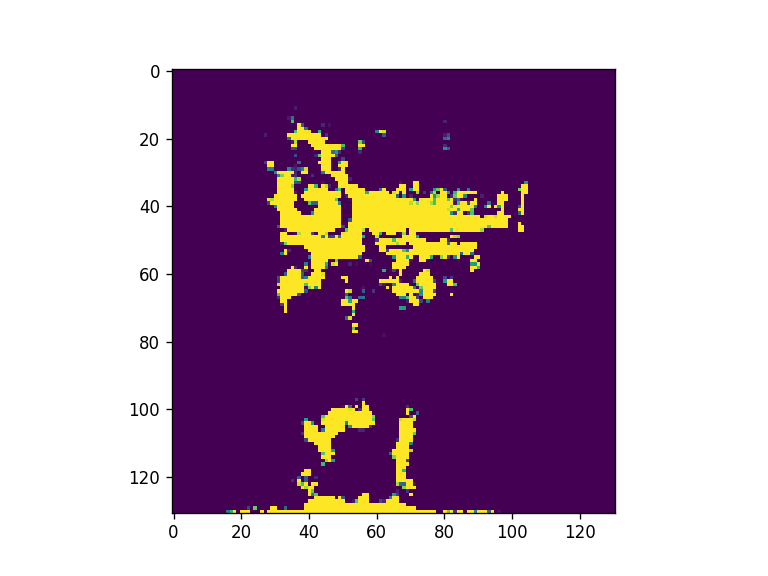

In [23]:
fig, ax = plt.subplots()
ax.imshow(density[110, :, :], vmin=0, vmax=4)

In [468]:
d_id = 0
axis = 0
if axis == 0:
    pos = torch.where(density[d_id, :, :] > 0)
    print(density[d_id, pos[0], pos[1]])
elif axis == 1:
    pos = torch.where(density[:, d_id, :] > 0)
    print(density[pos[0], d_id, pos[1]])
elif axis == 2:
    pos = torch.where(density[:, :, d_id] > 0)
    print(density[pos[0], pos[1], d_id])

tensor([0.1514, 0.6756, 0.0849, 0.2183, 1.2151, 0.9933, 0.0472, 0.6967, 0.5717,
        1.3632, 1.2642, 0.7048, 1.5699, 0.5310, 0.3577, 0.1502, 0.3868, 0.0730,
        0.4908, 0.1095, 1.4605, 0.2093, 0.0314, 0.1611, 0.3214, 0.3547, 0.1428,
        0.0740, 0.5187, 0.2607, 0.0267, 0.0667, 0.0856, 0.5756, 1.5935, 0.4692,
        1.3454, 0.7637, 1.1090, 0.7109, 0.1314, 1.5282, 2.5153, 0.5895, 0.0070,
        0.0229, 0.9697, 0.1103, 2.0617, 0.5721, 0.3154, 0.2906, 1.4880, 0.9381,
        0.1185, 0.7965, 0.2795, 0.6974, 0.7517, 0.0030, 0.0456, 2.3138, 0.2546,
        0.1246, 0.2588, 0.5470, 0.3062, 0.4677, 0.8729, 0.5858, 0.7602, 0.4353,
        2.0060, 0.9046, 0.3540, 0.0971, 0.3400, 1.0824, 1.3927, 0.6689, 0.3450,
        0.6597, 0.7813, 0.5919, 0.3781, 0.1868, 0.2564, 1.0394, 0.0094, 0.0762,
        0.2449, 0.0210, 0.1582, 0.1858, 0.2386, 0.1208, 0.6654, 0.3493, 0.7040,
        0.0451, 0.1553, 0.5865, 2.0846, 0.5259, 0.4607, 0.9537, 0.3429, 0.6701,
        0.0933, 0.8246, 0.1935, 2.2579, 

In [184]:
density.shape

torch.Size([138, 135, 136])

In [14]:
def calc_potential_shrinkage(density):
    ooc_mask = density > 0
    resolution = torch.tensor(density.shape)
    xyz_min, xyz_max = torch.empty(3, dtype=torch.long), torch.empty(3, dtype=torch.long)
    i_coord = ooc_mask.amax(0)
    ij_coord = i_coord.amax(0)
    xyz_min[1] = torch.max(ij_coord, dim=0).indices
    xyz_max[1] = len(ij_coord) - torch.max(ij_coord.flip(0), dim=0).indices
    ik_coord = i_coord.amax(1)
    xyz_min[2] = torch.max(ik_coord, dim=0).indices
    xyz_max[2] = len(ik_coord) - torch.max(ik_coord.flip(0), dim=0).indices
    j_coord = ooc_mask.amax(1)
    ji_coord = j_coord.amax(1)
    xyz_min[0] = torch.max(ji_coord, dim=0).indices
    xyz_max[0] = len(ji_coord) - torch.max(ji_coord.flip(0), dim=0).indices
    print(f"Old Bounds: [0, 0, 0] -- {resolution}")
    print(f"New Bounds: {xyz_min} -- {xyz_max}")
    xyz_min, xyz_max

In [159]:
density_np = density.numpy()
d_sm = density_np[60:120, 60:120, 60:120]

In [72]:
z,x,y = (d_sm > 0.00).nonzero()

In [70]:
z.shape, x.shape, y.shape

((121806,), (121806,), (121806,))

<IPython.core.display.Javascript object>


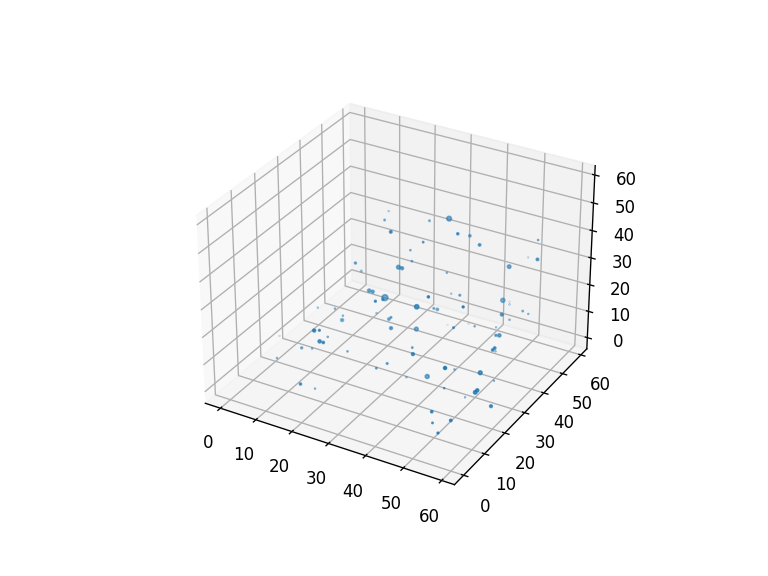

In [76]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# x, y, z = np.indices(d_sm.shape)
ax.scatter(x, y, z, s=density_np[z, x, y]*10)
# ax.scatter3D(x, y, z, s=d_sm.clamp(min=0)*1, c=d_sm);

In [14]:
def calc_potential_shrinkage(density):
    ooc_mask = density > 0
    resolution = torch.tensor(density.shape)
    xyz_min, xyz_max = torch.empty(3, dtype=torch.long), torch.empty(3, dtype=torch.long)
    i_coord = ooc_mask.amax(0)
    ij_coord = i_coord.amax(0)
    print(ij_coord.shape)
    xyz_min[2] = torch.max(ij_coord, dim=0).indices
    xyz_max[2] = len(ij_coord) - torch.max(ij_coord.flip(0), dim=0).indices
    ik_coord = i_coord.amax(1)
    print(ik_coord.shape)
    xyz_min[1] = torch.max(ik_coord, dim=0).indices
    xyz_max[1] = len(ik_coord) - torch.max(ik_coord.flip(0), dim=0).indices
    j_coord = ooc_mask.amax(1)
    ji_coord = j_coord.amax(1)
    print(ji_coord.shape)
    xyz_min[0] = torch.max(ji_coord, dim=0).indices
    xyz_max[0] = len(ji_coord) - torch.max(ji_coord.flip(0), dim=0).indices
    print(f"Old Bounds: [0, 0, 0] -- {resolution}")
    print(f"New Bounds: {xyz_min} -- {xyz_max}")
    xyz_min, xyz_max

In [19]:
density = torch.zeros(5, 4, 3)
density[2, 0, 1] = 1
density[2, 2, 2] = 1
calc_potential_shrinkage(density)

torch.Size([3])
torch.Size([4])
torch.Size([5])
Old Bounds: [0, 0, 0] -- tensor([5, 4, 3])
New Bounds: tensor([2, 0, 1]) -- tensor([3, 3, 3])


In [239]:
density = torch.zeros(3, 3, 3)
density[1, 1, 1] = 1
density[1, 2, 1] = 1
calc_potential_shrinkage(density)

Old Bounds: [0, 0, 0] -- tensor([3, 3, 3])
New Bounds: tensor([1, 1, 1]) -- tensor([2, 3, 2])


In [243]:
density = torch.zeros(3, 3, 3)
density[1, 0, 2] = 1
density[2, 1, 1] = 1
calc_potential_shrinkage(density)

Old Bounds: [0, 0, 0] -- tensor([3, 3, 3])
New Bounds: tensor([1, 0, 1]) -- tensor([3, 2, 3])
